In [1]:
import base64
from datetime import date, datetime
import json
import os
import random
import re
import time

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
plt.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
from tqdm import tqdm

# Set random seed for reproducibility
def set_seeds(seed=777):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

SEED = 777
set_seeds(SEED)
print(f'Random seed set to: {SEED}')
# Checking
print(np.random.rand(3))
set_seeds(SEED)
print(np.random.rand(3))

def print_all(df): 
    with pd.option_context('display.max_rows',None):
        with pd.option_context('display.max_columns',None):
            with pd.option_context('display.float_format', '{:,.4f}'.format):
                with pd.option_context('display.float_format', '{:,.4f}'.format):
                    print(df.shape)
                    display(df)

def print_cols(df, n=5): 
    with pd.option_context('display.max_columns',None):
        with pd.option_context('display.float_format', '{:,.4f}'.format):
            print(df.shape)
            display(df[:n])

Random seed set to: 777
[0.15266373 0.30235661 0.06203641]
[0.15266373 0.30235661 0.06203641]


In [2]:
import math

from joblib import Parallel, delayed
from matplotlib.colors import LinearSegmentedColormap

import scipy.stats as stats
from scipy.stats import mannwhitneyu, shapiro, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
def get_profile(df, check_duplicate_columns=True, as_it_is=True):
    '''
    Generate summary statistics for each column of the input DataFrame and return as a DataFrame
    
    Parameters
    ------------------
    df: DataFrame
    check_duplicate_columns: True/False; whether to check for duplicate columns (default: True)
    as_it_is: if convertible to numeric type, convert and aggregate (default: True)
    
    Information
    ------------------
    Returns results according to column data type (string, numeric (integer/float), etc.)
    
    Return information
    - Record count, mean, standard deviation, coefficient of variation, min, 1st quartile, median (2nd quartile), 3rd quartile, max, 
        null count, blank count, zero count, most frequent value, max frequency, least frequent value, min frequency, etc.
    '''
    # Function to display entire DataFrame
    def print_all(df):
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
                               'display.float_format', '{:,.4f}'.format):
            display(df)
    
    # Function to check numeric value length
    def number_length(n):
        if n > 0:
            digits = math.inf if math.isinf(n) else int(math.log10(n)) + 1
        elif n == 0:
            digits = 1
        elif n < 0:
            digits = math.inf if math.isinf(n) else int(math.log10(-n)) + 1
        else:
            digits = None
        return digits
    # Function to add percentage
    def add_pct(v, num_observations):
        if v > 0:
            new_v = round((v / num_observations) * 100, 2)
            return f'{str(v)}({new_v}%)'
        else:
            return v
    # Function to check if convertible to numeric
    def is_convertible_to_numeric(series):
        try:
            pd.to_numeric(series, errors='raise')
            return True
        except (ValueError, TypeError):
            return False
    # Main calculation function
    def calculate_stuff(df, col, num_observations, as_it_is):
        try:
            # Convert to numeric if as_it_is is False
            if as_it_is:
                col_df = df[col].copy()
            else:
                try:
                    col_df = pd.to_numeric(df[col]).copy()
                except Exception:
                    col_df = df[col].copy()
            
            # Get basic column information
            col_data_type = col_df.dtypes
            all_can_be_num = is_convertible_to_numeric(col_df)
            
            # Calculate value counts
            value_count = col_df.dropna().count()
            value_count = add_pct(value_count, num_observations)
            unique_count = col_df.dropna().nunique()
            
            # Calculate missing and special value counts
            null_count = col_df.isna().sum()
            null_count = add_pct(null_count, num_observations)
            blank_count = ((col_df == '') | (col_df == ' ') | (col_df == '  ')).sum()
            blank_count = add_pct(blank_count, num_observations)
            zero_count = ((col_df == 0) | (col_df == '0')).sum()
            zero_count = add_pct(zero_count, num_observations)
            
            # If current data type is numeric
            if col_df.dropna().dtype in [np.int16, np.int32, np.int64, float]:
                # Count special characters (excluding . and -)
                special_chars = set(string.punctuation.replace('.', '').replace('-', ''))
                special_char_count = col_df.dropna().apply(
                    lambda x: any(s for s in special_chars if s in str(x))
                ).sum()
                special_char_count = add_pct(special_char_count, num_observations)
                
                # Count negative values
                negative_count = (col_df < 0).sum()
                negative_count = add_pct(negative_count, num_observations)
                
                # Calculate statistical measures
                mean_value = col_df.dropna().mean() # mean
                std_value = col_df.dropna().std() # standard deviation
                coeff_variation = std_value / mean_value if mean_value != 0 else None # coefficient of variation (CV): relative dispersion of data
                
                # Calculate quartiles and extremes
                min_value = col_df.dropna().min() # min
                q1 = np.percentile(col_df.dropna(), 25) if len(col_df.dropna()) > 0 else None # q1
                median_value = col_df.dropna().median() if len(col_df.dropna()) > 0 else None # q2
                q3 = np.percentile(col_df.dropna(), 75) if len(col_df.dropna()) > 0 else None # q3
                max_value = col_df.dropna().max() # max
                
                # Calculate numeric length (number of digits)
                max_length = col_df.dropna().apply(lambda x: number_length(x)).max()
                min_length = col_df.dropna().apply(lambda x: number_length(x)).min()
            
            # If current data type is non-numeric (string, object, category, etc.)
            else:
                # Convert to string for consistent handling
                col_str = col_df.dropna().astype(str)
                
                # Count all special characters
                special_chars = set(string.punctuation)
                special_char_count = col_str.apply(
                    lambda x: any(s for s in special_chars if s in x)
                ).sum()
                special_char_count = add_pct(special_char_count, num_observations)
                
                # Set numeric-only statistics to None or 0
                negative_count = 0
                mean_value = None
                std_value = None
                coeff_variation = None
                
                # Get min/max values
                min_value = col_str.min() if len(col_str) > 0 else None
                q1 = None
                median_value = None
                q3 = None
                max_value = col_str.max() if len(col_str) > 0 else None
                
                # Calculate string length
                max_length = col_str.apply(lambda x: len(x)).max() if len(col_str) > 0 else None
                min_length = col_str.apply(lambda x: len(x)).min() if len(col_str) > 0 else None
            
            # Calculate frequency statistics
            try:
                most_frequent_value = col_df.dropna().value_counts().idxmax()
                most_frequency = col_df.dropna().value_counts().max()
                least_frequent_value = col_df.dropna().value_counts().idxmin()
                least_frequency = col_df.dropna().value_counts().min()
            except:
                most_frequent_value = None
                most_frequency = None
                least_frequent_value = None
                least_frequency = None

            result_list = [
                col, col_data_type, all_can_be_num, value_count, unique_count, 
                null_count, blank_count, zero_count, special_char_count, negative_count, 
                mean_value, std_value, coeff_variation, min_value, q1, median_value, q3, max_value, 
                most_frequent_value, most_frequency, least_frequent_value, least_frequency, 
                max_length, min_length
            ]
            return result_list
        except Exception as e:
            print(f"Error processing column {col}: {e}")
            return [col] + [None] * 23
    
    ## Profile overview
    print('## Overview \n')
    
    # Display basic dataframe info
    print(df.info(verbose=False) or '')
    num_observations = df.shape[0]
    num_vars = df.shape[1]
    print('Number of variables:', num_vars)
    print('Number of observations:', num_observations)
    
    # Calculate total missing cells
    total_null = df.isna().sum().sum()
    total_blank = (df == '').sum(axis=0).sum() + (df == ' ').sum(axis=0).sum() + (df == '  ').sum(axis=0).sum()
    total_missing = total_null + total_blank
    total_missing_pct = round(total_missing / (num_observations * num_vars) * 100, 2)
    print('Total missing cells:', total_missing)
    print('Total missing cells (%):', total_missing_pct)
    
    # Check for duplicate columns if requested
    if check_duplicate_columns:
        duplicate_cols = df.columns[df.T.duplicated(keep=False)].tolist()
        num_duplicate_cols = len(duplicate_cols)
        print('Duplicate columns:', duplicate_cols)
        print('Duplicate columns (count):', num_duplicate_cols)
    
    # Check for duplicate rows
    duplicate_rows = df.index[df.duplicated(keep=False)].to_list()
    num_duplicate_rows = len(duplicate_rows)
    print('Duplicate rows:', duplicate_rows)
    print('Duplicate rows (count):', num_duplicate_rows)

    print('\n## Details')
    
    # Calculate statistics for each column in parallel
    workers = os.cpu_count()
    profiles_list = Parallel(backend='loky', n_jobs=workers)(
        delayed(calculate_stuff)(df, col, num_observations, as_it_is) 
        for col in df.columns.tolist()
    )

    # Create result dataframe
    profile_df = pd.DataFrame(
        profiles_list, 
        columns=[
            'col', 'dtype', 'all_can_be_num', 'value_cnt', 'nunique', 
            'null_cnt', 'blank_cnt', 'zero_cnt', 'spec_char_cnt', 'neg_cnt', 
            'mean', 'std', 'cv', 'min', '25%', 'median', '75%', 'max',
            'most_freq_val', 'most_freq_cnt', 'least_freq_val', 'least_freq_cnt', 
            'max_length', 'min_length'
        ]
    )

    return print_all(profile_df)

---

In [ ]:
# ===================================================================
# configurations

# path
# get the path of the current script file
CURRENT_DIR = os.getcwd()
print(CURRENT_DIR)

# move up one level to the parent directory
PARENT_DIR = os.path.dirname(os.getcwd())
print(PARENT_DIR)

# path to data directory
DATA_ROOT = os.path.join(CURRENT_DIR, 'data')
print(DATA_ROOT)

# path to dataset file
DATA_FILE_PATH = os.path.join(DATA_ROOT, 'default of credit card clients.xlsx')
print(DATA_FILE_PATH)

In [5]:
# MSU colors (Spartan Green + White)
msu_colors = ['#D3D3D3', '#18453B'] # Primary: #18453B(Spartan Green), Secondary: #909090(Warm Gray), #D7D2CB(Clay), #D3D3D3(Light Gray)
sns.set_palette(sns.color_palette(msu_colors))
plt.rcParams['figure.facecolor'] = 'white' # white as background

In [6]:
# target column
target_col = 'def_pay'

# mapping dictionaries
mapping_dicts = {
    'sex': {1: 'Male', 2: 'Female'},
    'education': {1: 'Graduate School', 2: 'University', 3: 'High School', 4: 'Others'},
    'marriage': {1: 'Married', 2: 'Single', 3: 'Others'},
    f'{target_col}': {0: 'No Default', 1: 'Default'}
}

column_mapping = {
    # numerical
    'limit_bal': 'Credit Limit (NT Dollars)',
    'age': 'Age',
    
    # binary / categorical
    'sex': 'Gender',
    'education': 'Education',
    'marriage': 'Marriage',
    'def_pay': 'Default Next Month',
    
    # pay_x (ordinal)
    'pay_1': '0 Month Ago Status (Repayment Delay Months)',
    'pay_2': '1 Month Ago Status (Repayment Delay Months)',
    'pay_3': '2 Months Ago Status (Repayment Delay Months)',
    'pay_4': '3 Months Ago Status (Repayment Delay Months)',
    'pay_5': '4 Months Ago Status (Repayment Delay Months)',
    'pay_6': '5 Months Ago Status (Repayment Delay Months)',
    
    # bill_amt_x (numerical)
    'bill_amt1': '0 Month Ago Bill',
    'bill_amt2': '1 Month Ago Bill',
    'bill_amt3': '2 Months Ago Bill',
    'bill_amt4': '3 Months Ago Bill',
    'bill_amt5': '4 Months Ago Bill',
    'bill_amt6': '5 Months Ago Bill',
    
    # pay_amt_x (numerical)
    'pay_amt1': '0 Month Ago Payment',
    'pay_amt2': '1 Month Ago Payment',
    'pay_amt3': '2 Months Ago Payment',
    'pay_amt4': '3 Months Ago Payment',
    'pay_amt5': '4 Months Ago Payment',
    'pay_amt6': '5 Months Ago Payment'
}

---

# Data Load

```
There are 25 variables:

ID: ID of each client
LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
SEX: Gender (1=male, 2=female)
EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
MARRIAGE: Marital status (1=married, 2=single, 3=others)
AGE: Age in years
PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
PAY_2: Repayment status in August, 2005 (scale same as above)
PAY_3: Repayment status in July, 2005 (scale same as above)
PAY_4: Repayment status in June, 2005 (scale same as above)
PAY_5: Repayment status in May, 2005 (scale same as above)
PAY_6: Repayment status in April, 2005 (scale same as above)
BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
default payment next month: Default payment (1=yes, 0=no)
```

In [7]:
# load dataset
raw_df = pd.read_excel(DATA_FILE_PATH, header=1) # index_col=0

print_cols(raw_df, 2)

(30000, 25)


ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2       3913       3102        689          0          0   
1      0      2       2682       1725       2682       3272       3455   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0          0         0       689         0         0         0         0   
1       3261         0      1000      1000      1000         0      2000   

   default payment next month  
0                           1  
1                           1

In [8]:
# copy
df = raw_df.copy()

# rename columns
df.columns = [col.lower() for col in df.columns]
df.rename(columns={'default payment next month':'def_pay'}, inplace=True)
df.rename(columns={'pay_0':'pay_1'}, inplace=True)
df.drop(columns=['id'], inplace=True)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'def_pay'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   limit_bal  30000 non-null  int64
 1   sex        30000 non-null  int64
 2   education  30000 non-null  int64
 3   marriage   30000 non-null  int64
 4   age        30000 non-null  int64
 5   pay_1      30000 non-null  int64
 6   pay_2      30000 non-null  int64
 7   pay_3      30000 non-null  int64
 8   pay_4      30000 non-null  int64
 9   pay_5      30000 non-null  int64
 10  pay_6      30000 non-null  int64
 11  bill_amt1  30000 non-null  int64
 12  bill_amt2  30000 non-null  int64
 13  bill_amt3  30000 non-null  int64
 14  bill_amt4  30000 non-null  int64
 15  bill_amt5  30000 non-null  int64
 16  bill_amt6  30000 non-null  int64
 17  pay_amt1   30000 non-null  int64
 18  pay_amt2   30000 non-null  int64
 19  pay_amt3   30000 non-null  int64
 20  pay_amt4   30000 non-null  int64
 21  pay_amt5   3

In [10]:
# sex, education, marriage, pay_0, pay_2, pay_3, pay_4, pay_5, pay_6, default payment next month 
# = categorical features 

# convert datatype of categorical features from integer -> category
df.sex = df.sex.astype('category')
df.education = df.education.astype('category')
df.marriage = df.marriage.astype('category')
df.pay_1 = df.pay_1.astype('category')
df.pay_2 = df.pay_2.astype('category')
df.pay_3 = df.pay_3.astype('category')
df.pay_4 = df.pay_4.astype('category')
df.pay_5 = df.pay_5.astype('category')
df.pay_6 = df.pay_6.astype('category')
df[target_col] = df[target_col].astype('category')

# Initial Cleaning

In [11]:
# clean up categorical columns

# education: 0, 4, 5, 6 = 'others' or 'unknown' --> lump into 4
df['education'] = df['education'].astype(int).replace(to_replace=[0, 5, 6], value=4).astype('category') # 4: others
print(df['education'].unique()) # -> [1, 2, 3, 4]

# marraige: 0='unknown', 3='others' --> lump into 3
df['marriage'] = df['marriage'].astype(int).replace(to_replace=0, value=3).astype('category') # 3: others
print(df['marriage'].unique()) # -> [1, 2, 3]

[2, 1, 3, 4]
Categories (4, int64): [1, 2, 3, 4]
[1, 2, 3]
Categories (3, int64): [1, 2, 3]


In [12]:
# simplify pay_1 ~ pay_6 --> turn them into clean "months overdue" (ordinal)

# -2 = paid in full, -1 = paid on time, 0 = no delay or revolving
# --> all mean "no overdue" so we lump them into 0
# result: easy-to-read "how many months late" scale
pay_cols = [f'pay_{i}' for i in range(1, 7)]
for col in pay_cols:
    df[col] = df[col].astype(int).replace(to_replace=[-2, -1], value=0).astype('category')
    print(df[col].unique())

[2, 0, 1, 3, 4, 8, 7, 5, 6]
Categories (9, int64): [0, 1, 2, 3, ..., 5, 6, 7, 8]
[2, 0, 3, 5, 7, 4, 1, 6, 8]
Categories (9, int64): [0, 1, 2, 3, ..., 5, 6, 7, 8]
[0, 2, 3, 4, 6, 7, 1, 5, 8]
Categories (9, int64): [0, 1, 2, 3, ..., 5, 6, 7, 8]
[0, 2, 3, 4, 5, 7, 6, 1, 8]
Categories (9, int64): [0, 1, 2, 3, ..., 5, 6, 7, 8]
[0, 2, 3, 5, 4, 7, 8, 6]
Categories (8, int64): [0, 2, 3, 4, 5, 6, 7, 8]
[0, 2, 3, 6, 4, 7, 8, 5]
Categories (8, int64): [0, 2, 3, 4, 5, 6, 7, 8]


# EDA and Visual

In [13]:
# target(y), features(X) split

X = df.drop(target_col, axis=1)
y = df[target_col]

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   limit_bal  30000 non-null  int64   
 1   sex        30000 non-null  category
 2   education  30000 non-null  category
 3   marriage   30000 non-null  category
 4   age        30000 non-null  int64   
 5   pay_1      30000 non-null  category
 6   pay_2      30000 non-null  category
 7   pay_3      30000 non-null  category
 8   pay_4      30000 non-null  category
 9   pay_5      30000 non-null  category
 10  pay_6      30000 non-null  category
 11  bill_amt1  30000 non-null  int64   
 12  bill_amt2  30000 non-null  int64   
 13  bill_amt3  30000 non-null  int64   
 14  bill_amt4  30000 non-null  int64   
 15  bill_amt5  30000 non-null  int64   
 16  bill_amt6  30000 non-null  int64   
 17  pay_amt1   30000 non-null  int64   
 18  pay_amt2   30000 non-null  int64   
 19  pay_amt3   30000 non-null

In [15]:
# define numerical and categorical cols
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

## Basic Stat

In [16]:
# generate summary statistics for each feature
get_profile(X, True, True)

## Overview 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 23 entries, limit_bal to pay_amt6
dtypes: category(9), int64(14)
memory usage: 3.5 MB

Number of variables: 23
Number of observations: 30000
Total missing cells: 0
Total missing cells (%): 0.0
Duplicate columns: []
Duplicate columns (count): 0
Duplicate rows: [18, 291, 627, 839, 881, 1093, 1211, 1601, 1697, 1759, 1964, 1980, 1983, 2621, 3468, 3600, 3768, 3787, 4089, 4436, 4585, 4864, 6022, 6124, 6160, 6169, 6313, 6466, 6740, 6785, 6993, 7170, 7266, 7319, 7366, 7373, 8297, 8320, 8377, 8574, 8611, 8871, 9221, 9407, 9644, 10250, 10374, 10741, 11083, 11367, 11550, 11741, 11976, 12087, 12430, 12432, 13106, 13556, 13912, 14294, 15212, 15458, 15617, 15685, 16200, 17032, 17284, 17879, 18301, 18325, 18777, 19114, 19487, 19499, 19604, 19897, 20028, 20875, 21466, 21768, 21881, 22162, 22726, 23655, 23679, 23871, 23877, 24122, 24361, 25608, 25653, 25891, 26058, 26249, 26805, 26993, 27295, 27351, 27765

col dtype all_can_be_num value_cnt nunique null_cnt blank_cnt  \
0   limit_bal  None           None      None    None     None      None   
1         sex  None           None      None    None     None      None   
2   education  None           None      None    None     None      None   
3    marriage  None           None      None    None     None      None   
4         age  None           None      None    None     None      None   
5       pay_1  None           None      None    None     None      None   
6       pay_2  None           None      None    None     None      None   
7       pay_3  None           None      None    None     None      None   
8       pay_4  None           None      None    None     None      None   
9       pay_5  None           None      None    None     None      None   
10      pay_6  None           None      None    None     None      None   
11  bill_amt1  None           None      None    None     None      None   
12  bill_amt2  None           None      None    None     None      None   
13  bill_amt3  None           None      None    None     None      None   
14  bill_amt4  None           None      None    None     None      None   
15  bill_amt5  None           None      None    None     None      None   
16  bill_amt6  None           None      None    None     None      None   
17   pay_amt1  None           None      None    None     None      None   
18   pay_amt2  None           None      None    None     None      None   
19   pay_amt3  None           None      None    None     None      None   
20   pay_amt4  None           None      None    None     None      None   
21   pay_amt5  None           None      None    None     None      None   
22   pay_amt6  None           None      None    None     None      None   

   zero_cnt spec_char_cnt neg_cnt  mean   std    cv   min   25% median   75%  \
0      None          None    None  None  None  None  None  None   None  None   
1      None          None    None  None  None  None  None  None   None  None   
2      None          None    None  None  None  None  None  None   None  None   
3      None          None    None  None  None  None  None  None   None  None   
4      None          None    None  None  None  None  None  None   None  None   
5      None          None    None  None  None  None  None  None   None  None   
6      None          None    None  None  None  None  None  None   None  None   
7      None          None    None  None  None  None  None  None   None  None   
8      None          None    None  None  None  None  None  None   None  None   
9      None          None    None  None  None  None  None  None   None  None   
10     None          None    None  None  None  None  None  None   None  None   
11     None          None    None  None  None  None  None  None   None  None   
12     None          None    None  None  None  None  None  None   None  None   
13     None          None    None  None  None  None  None  None   None  None   
14     None          None    None  None  None  None  None  None   None  None   
15     None          None    None  None  None  None  None  None   None  None   
16     None          None    None  None  None  None  None  None   None  None   
17     None          None    None  None  None  None  None  None   None  None   
18     None          None    None  None  None  None  None  None   None  None   
19     None          None    None  None  None  None  None  None   None  None   
20     None          None    None  None  None  None  None  None   None  None   
21     None          None    None  None  None  None  None  None   None  None   
22     None          None    None  None  None  None  None  None   None  None   

     max most_freq_val most_freq_cnt least_freq_val least_freq_cnt max_length  \
0   None          None          None           None           None       None   
1   None          None          None           None           None       None   
2   None          None          None         

- no missing values
- all bill amount variables and payment amount variables have high high variance

Rows: 30000, Columns: 23
Target:
def_pay
0    23364
1     6636
Name: count, dtype: int64


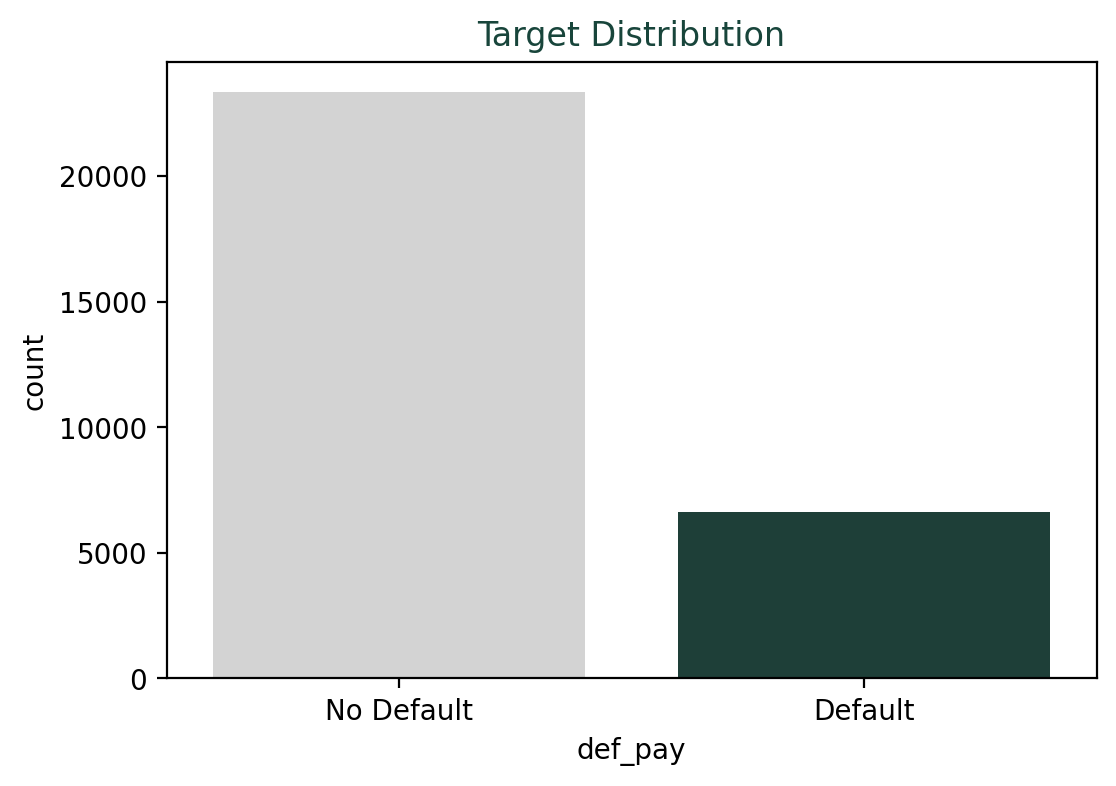

In [17]:
# data structure
print(f"Rows: {X.shape[0]}, Columns: {X.shape[1]}")
print(f"Target:\n{y.value_counts()}")

# target dist
plt.figure(figsize=(6, 4))
sns.countplot(
    x=y.map(mapping_dicts[target_col]),
    hue=y.map(mapping_dicts[target_col]), 
    palette=msu_colors)
plt.title('Target Distribution', color=msu_colors[1]) # fontweight='bold', 
plt.gca().set_facecolor('white')
plt.show()

In [18]:
# target ratio
y.value_counts(normalize=True) * 100

def_pay
0    77.88
1    22.12
Name: proportion, dtype: float64

- Imbalanced target (y)

## Numerical

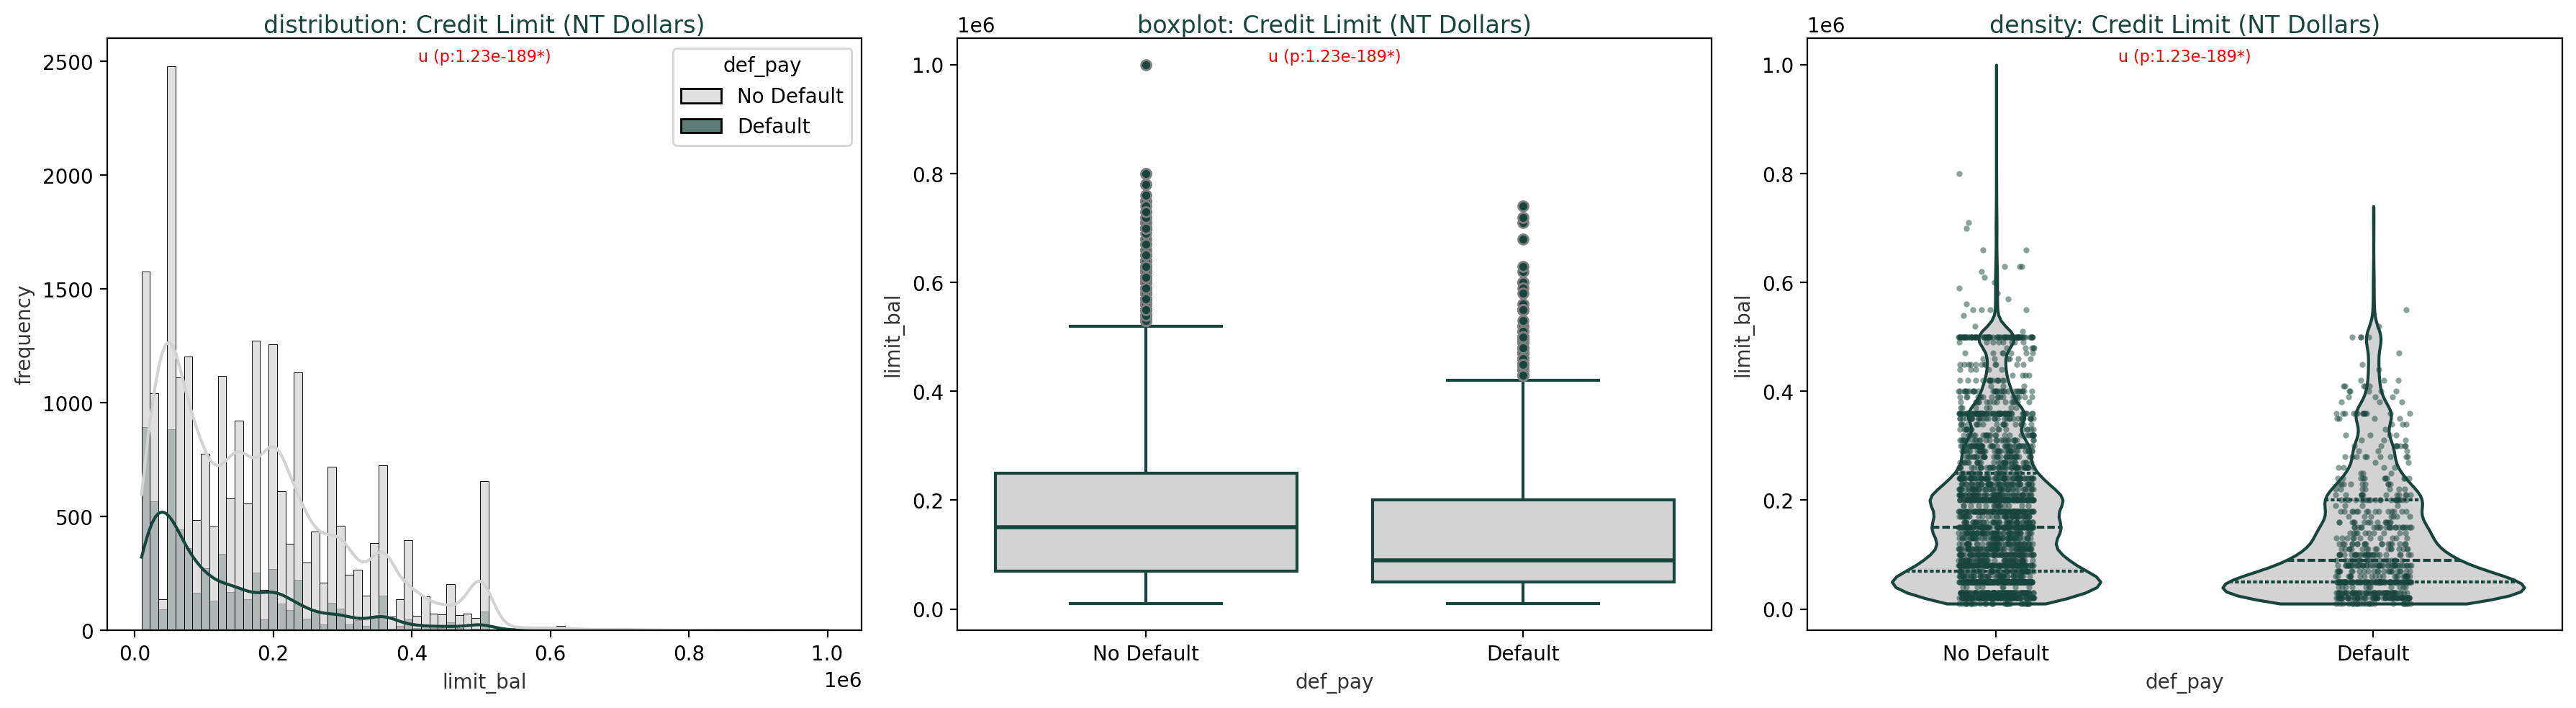

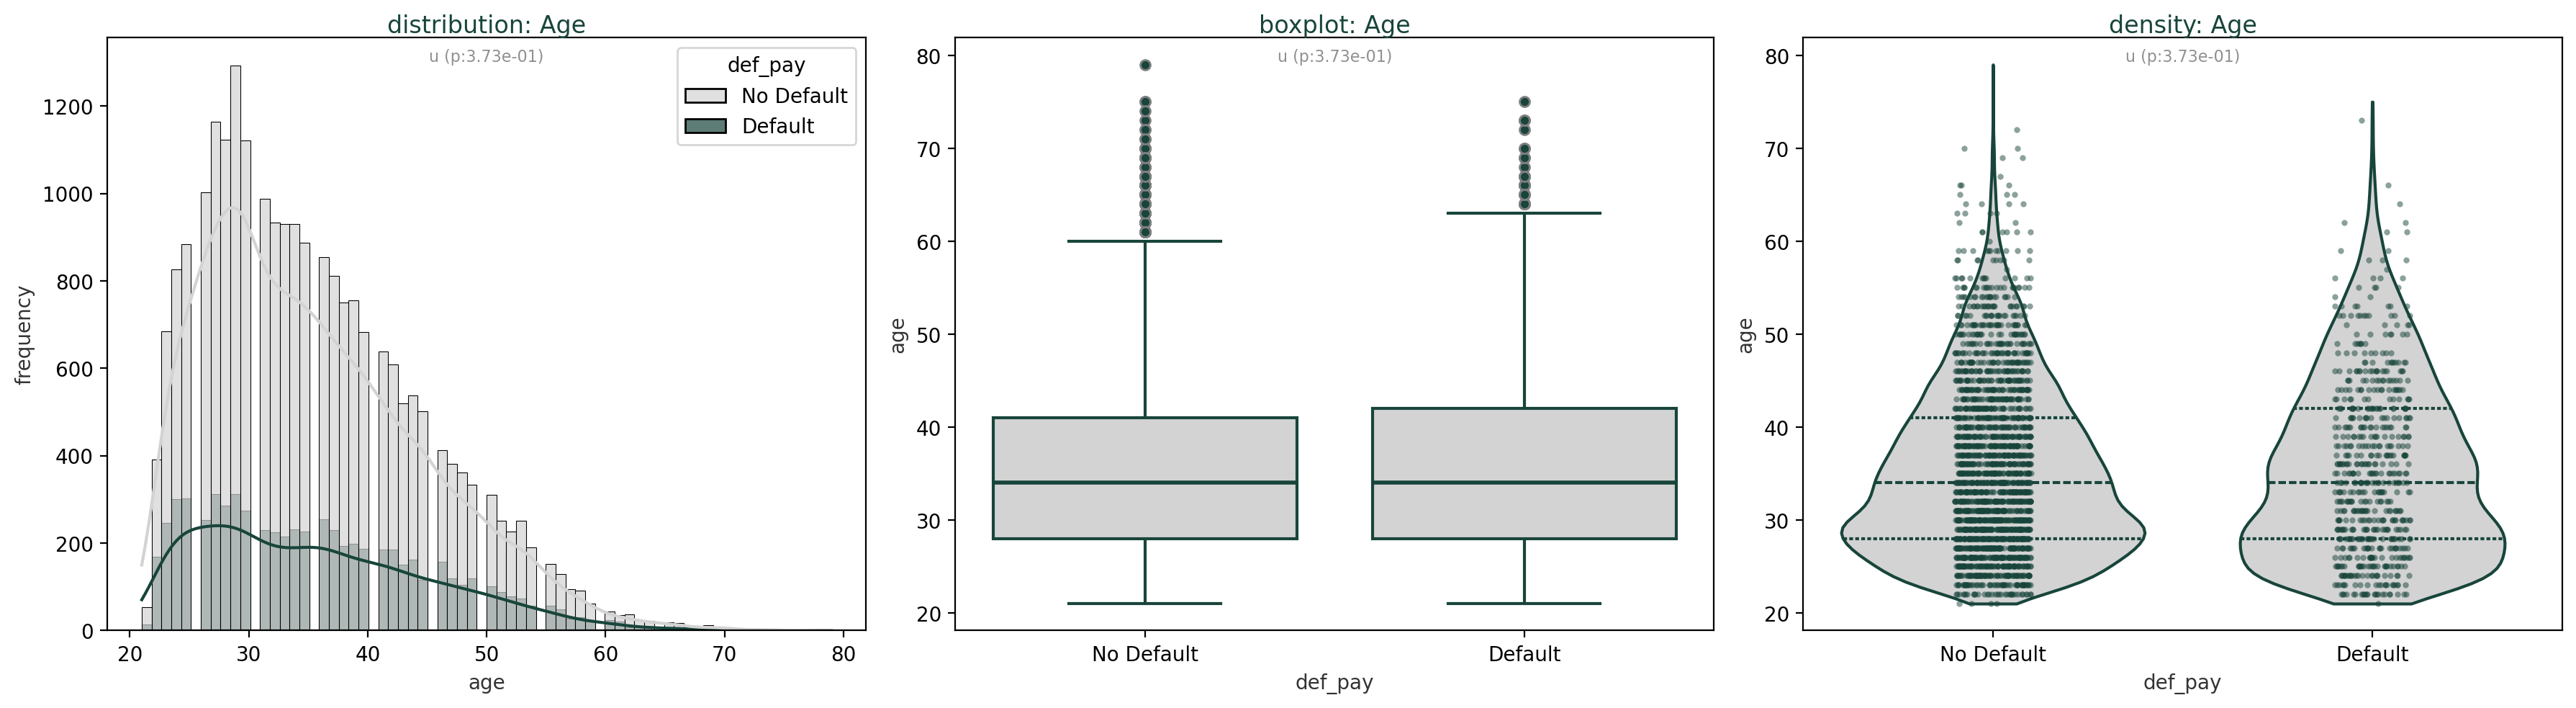

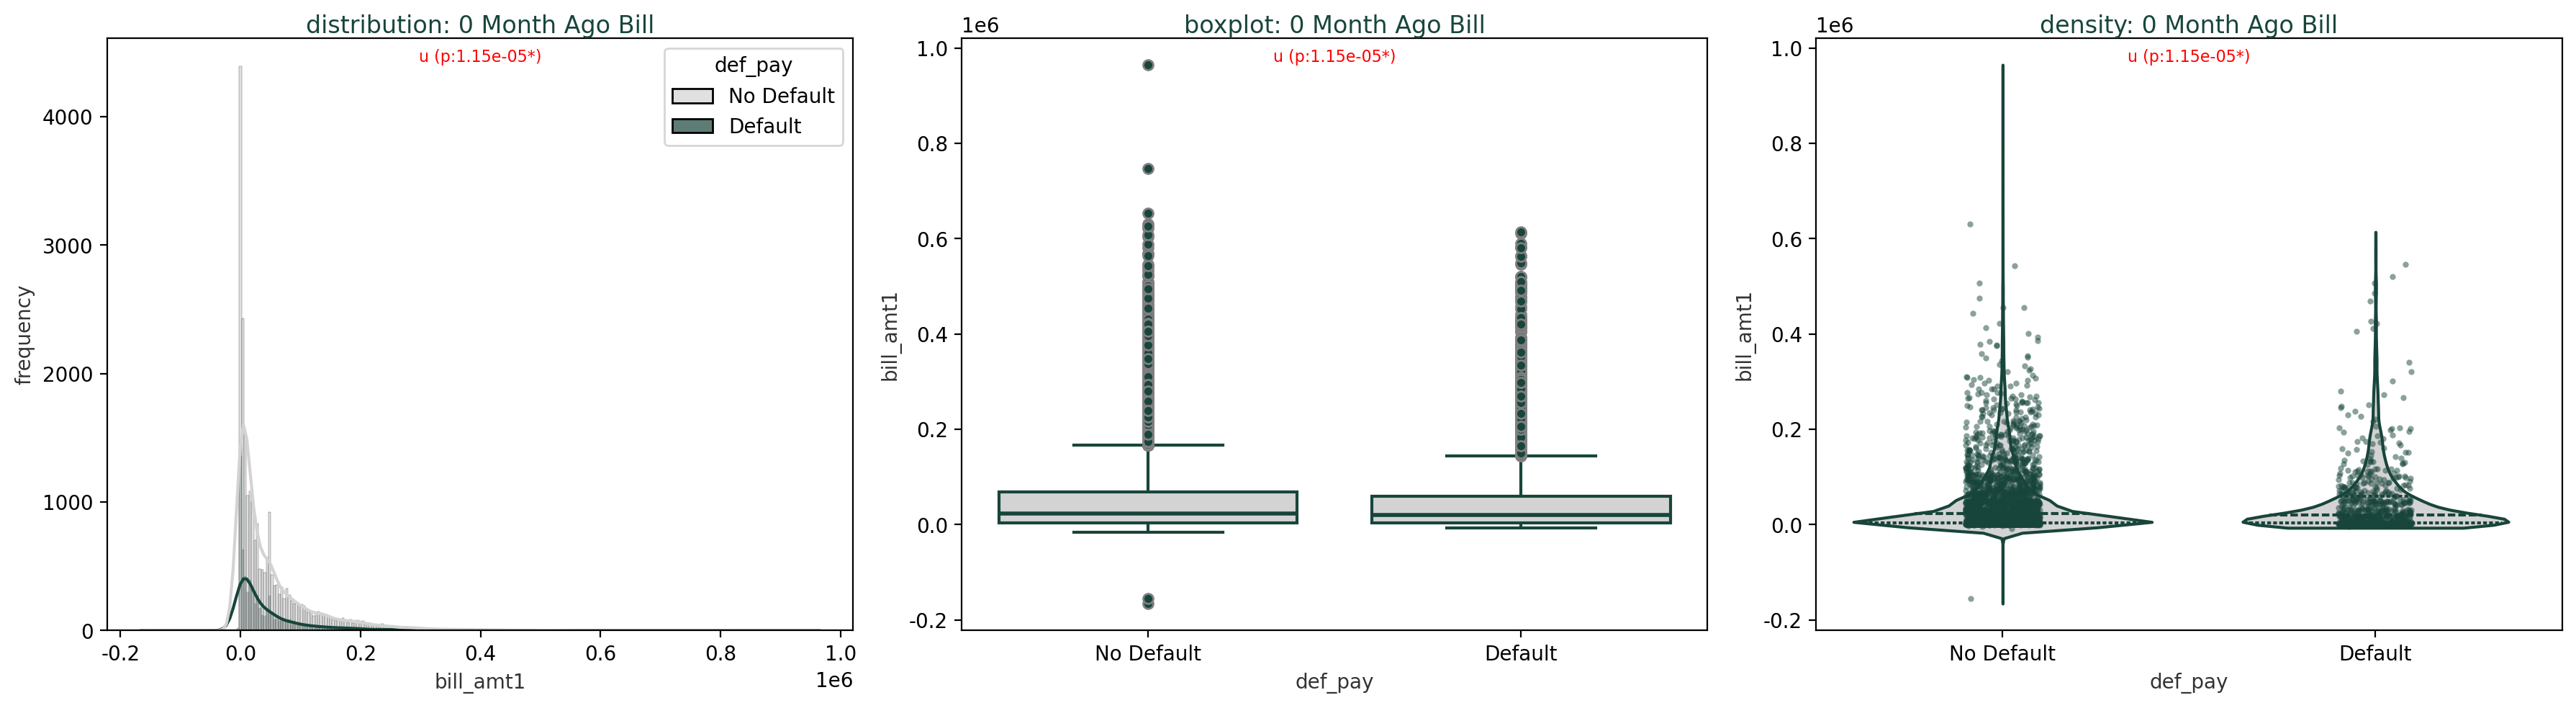

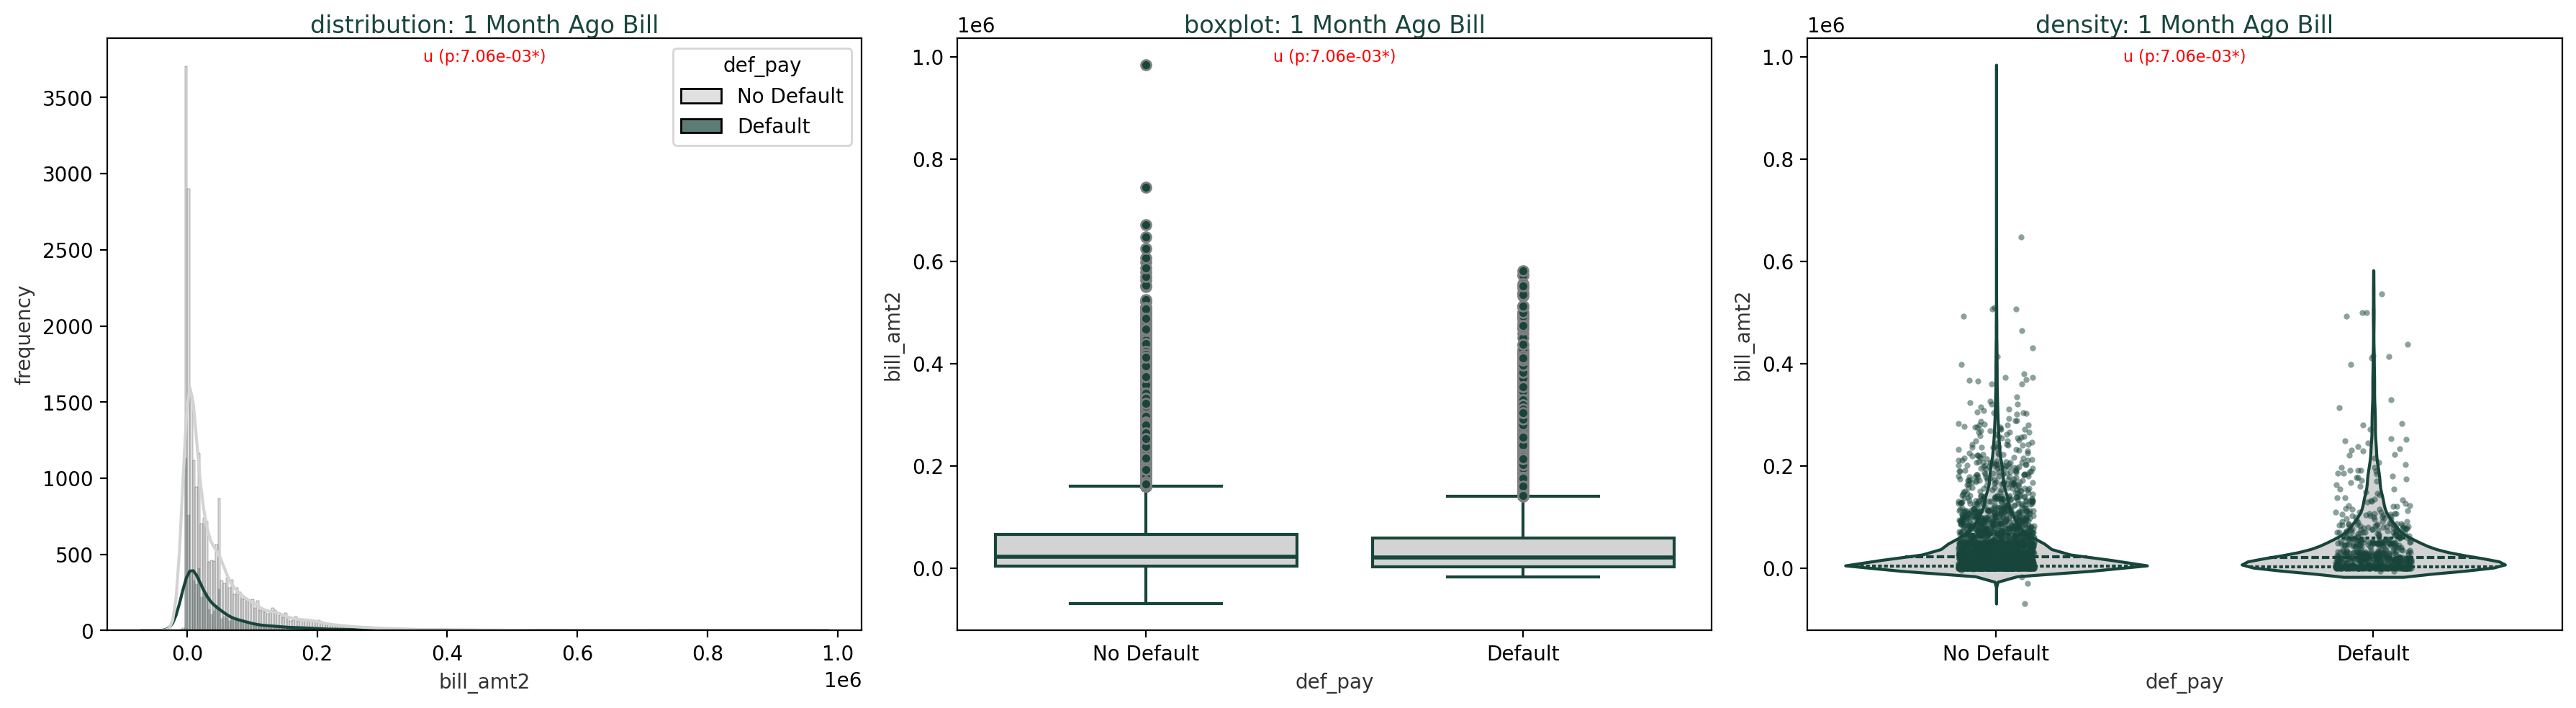

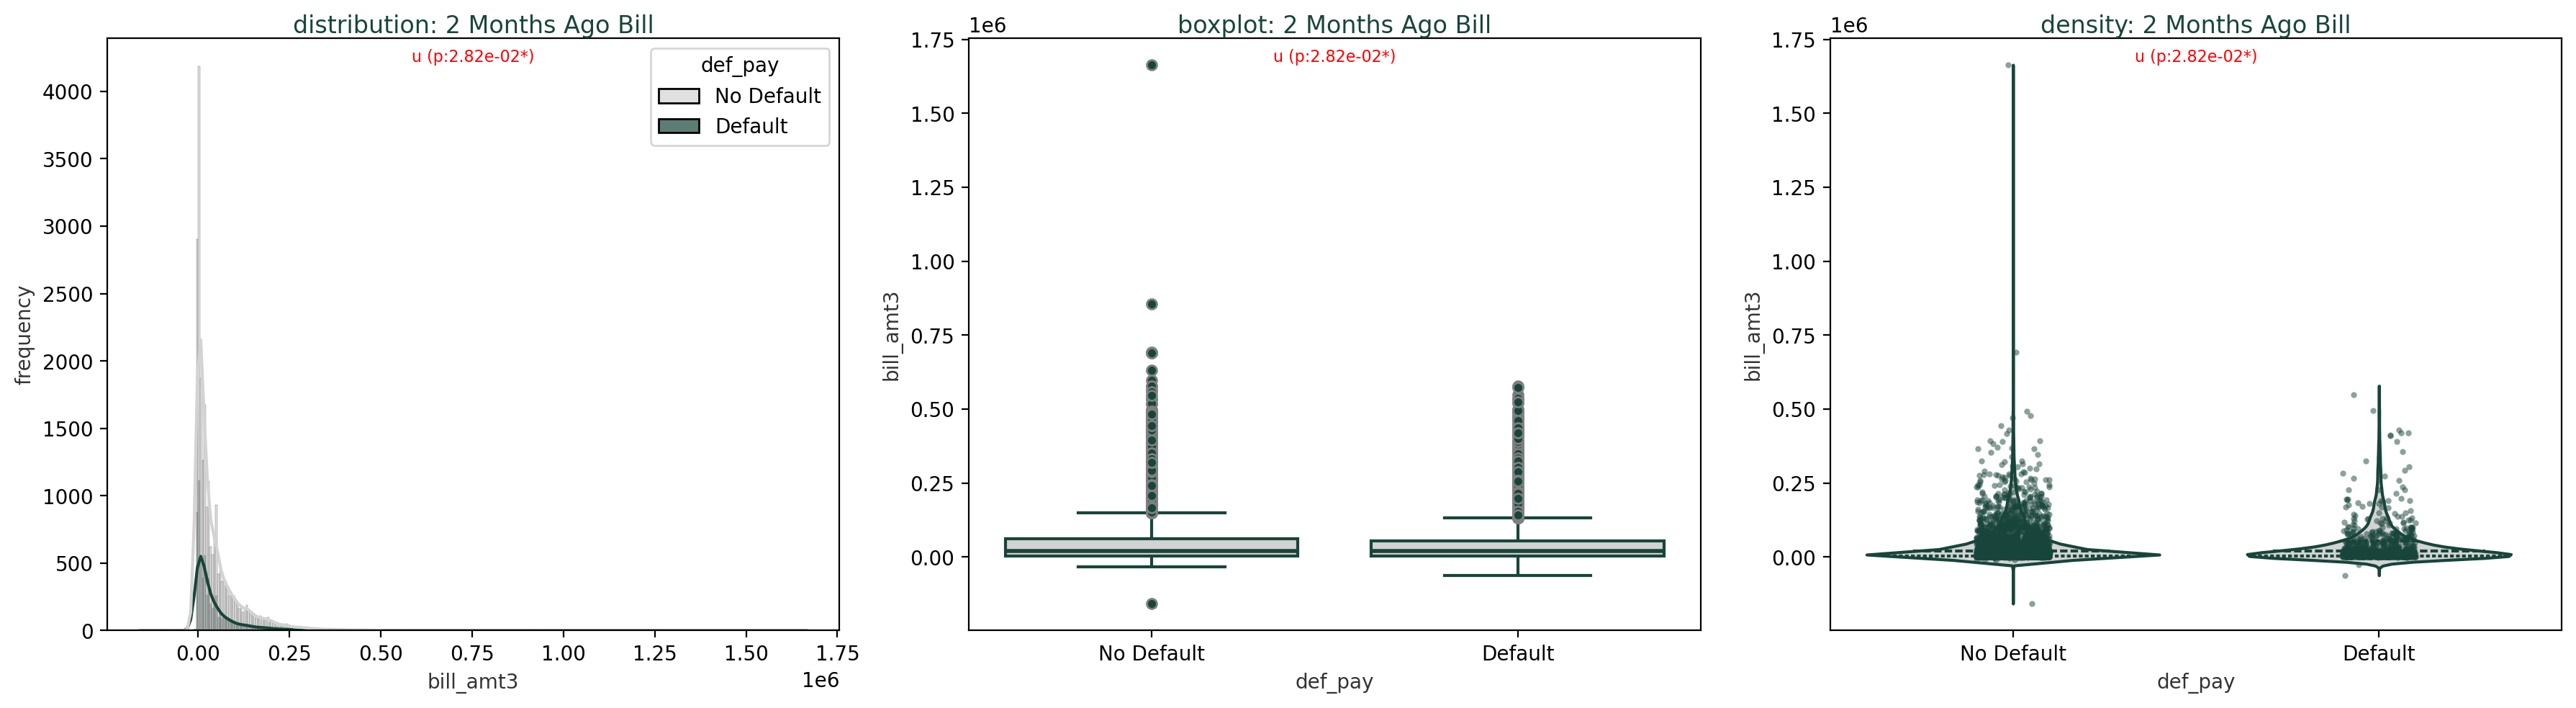

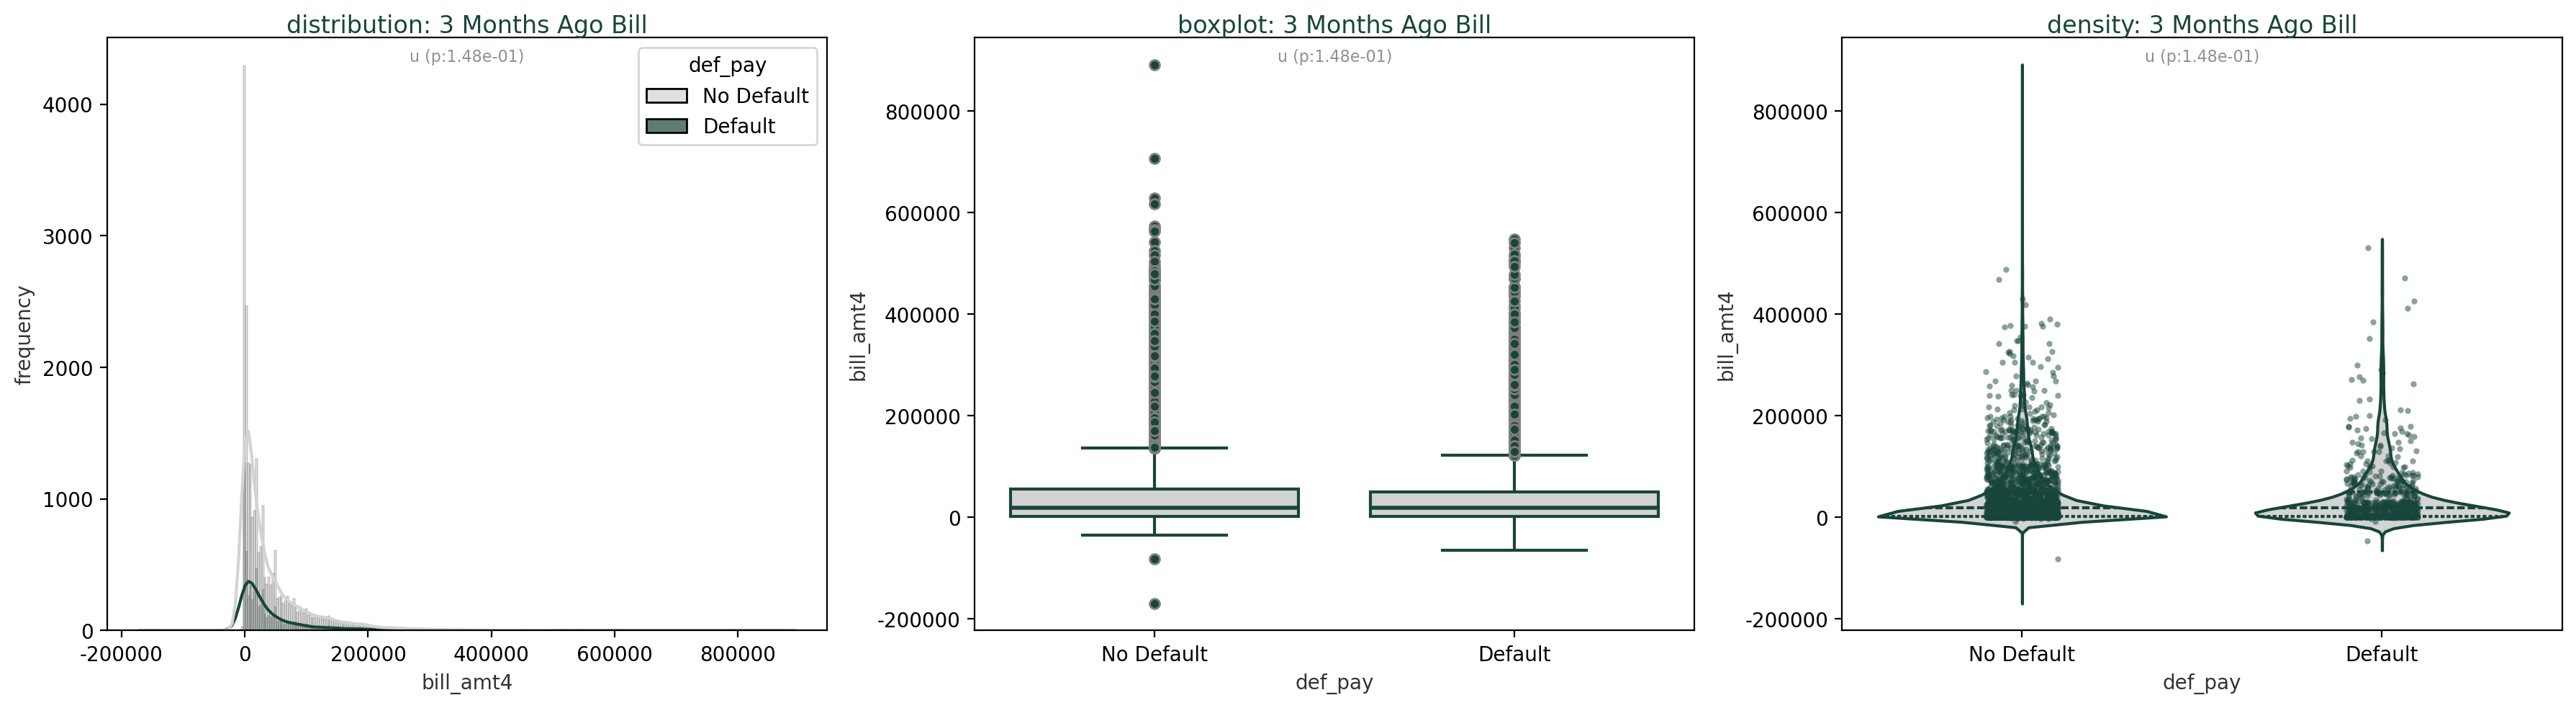

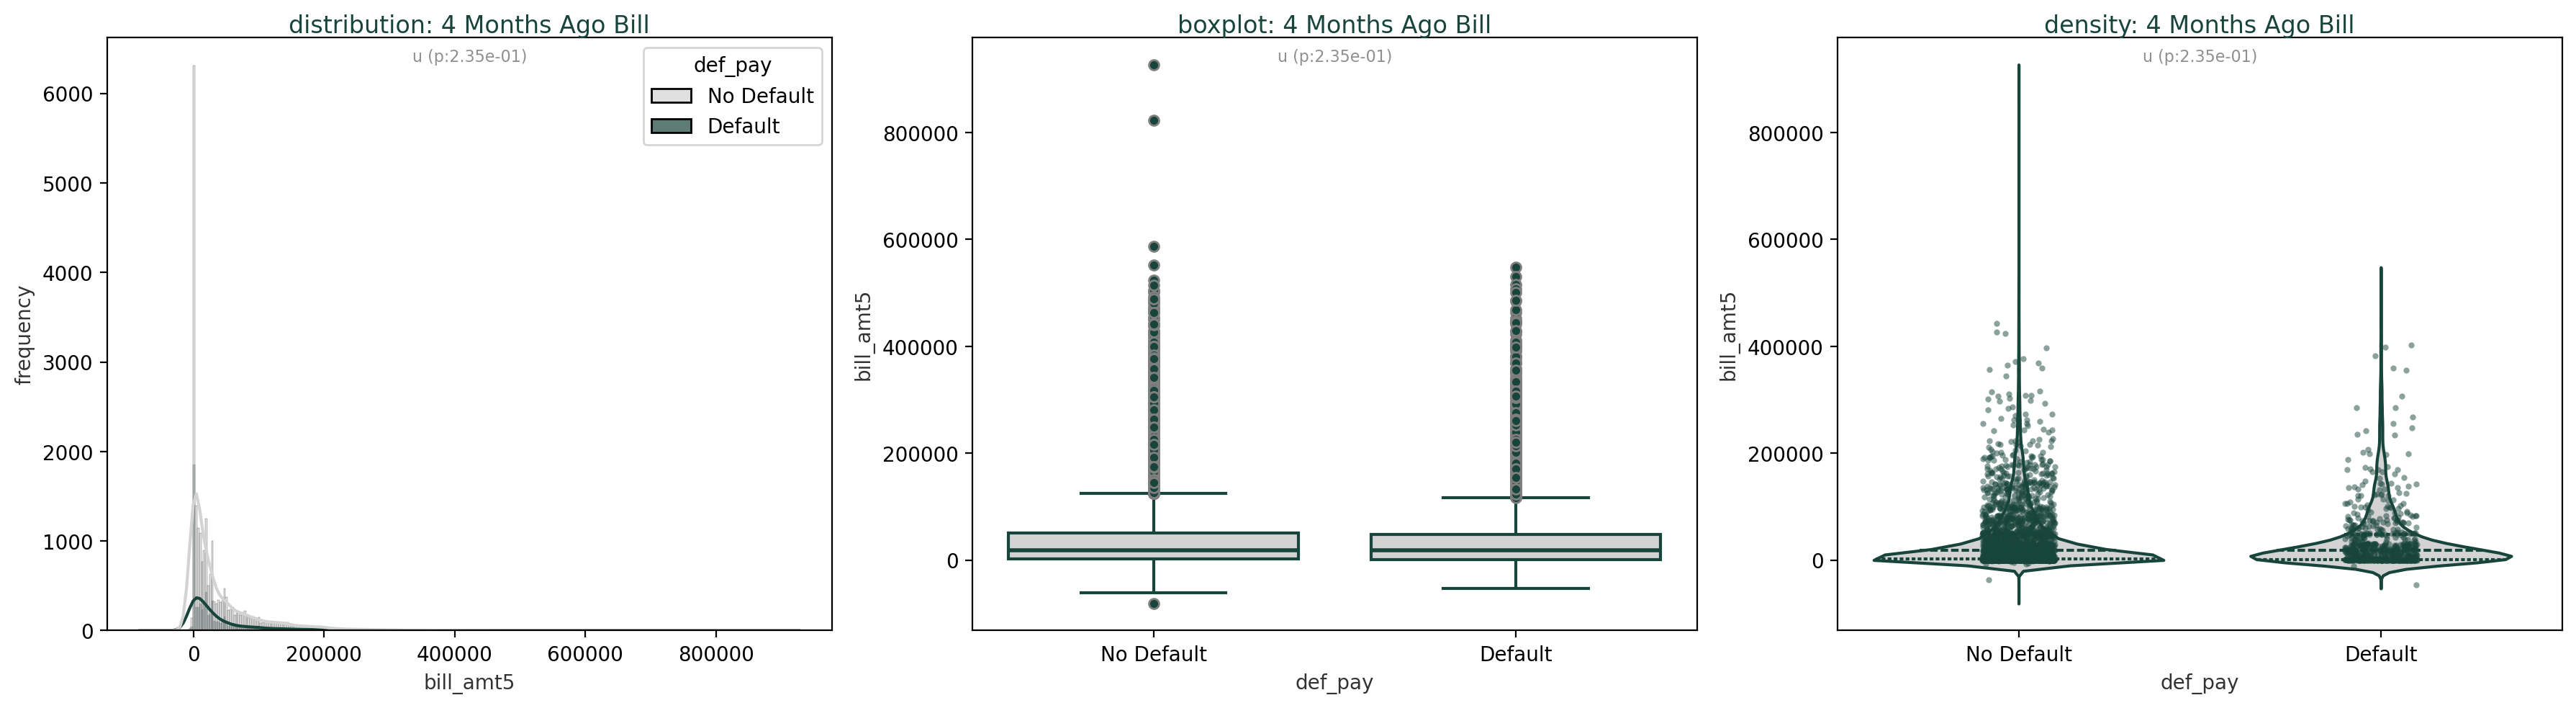

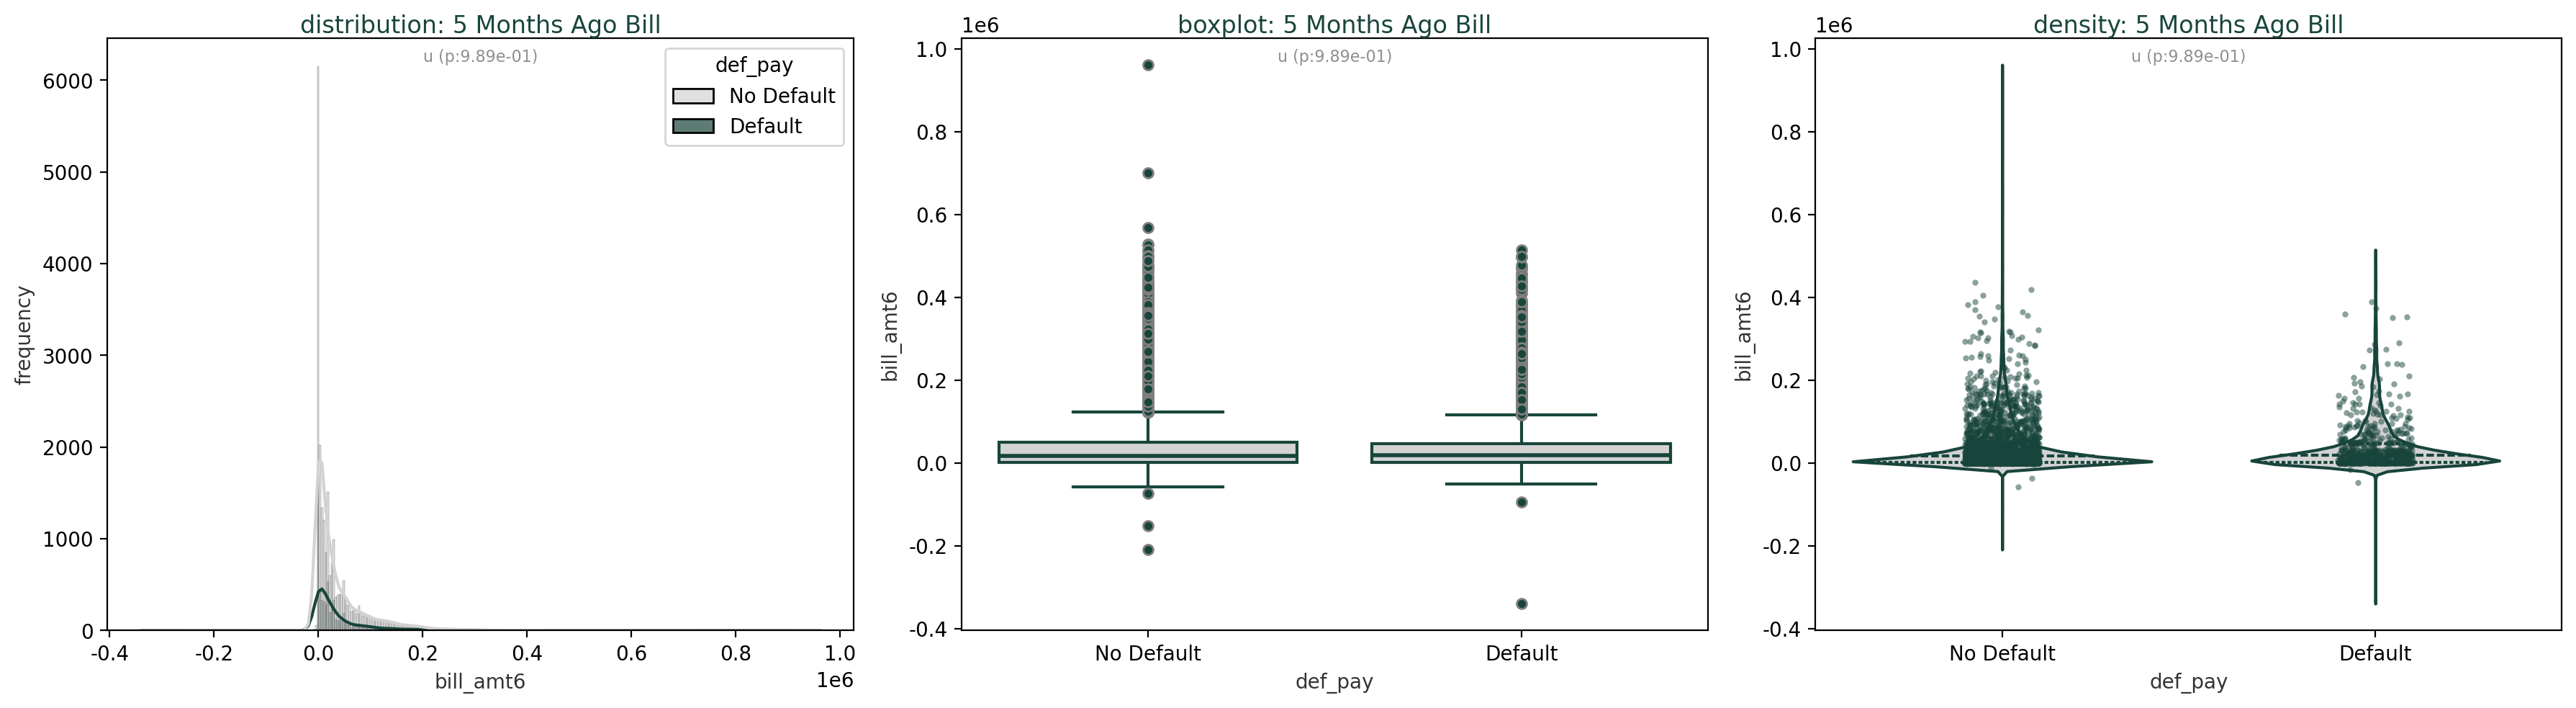

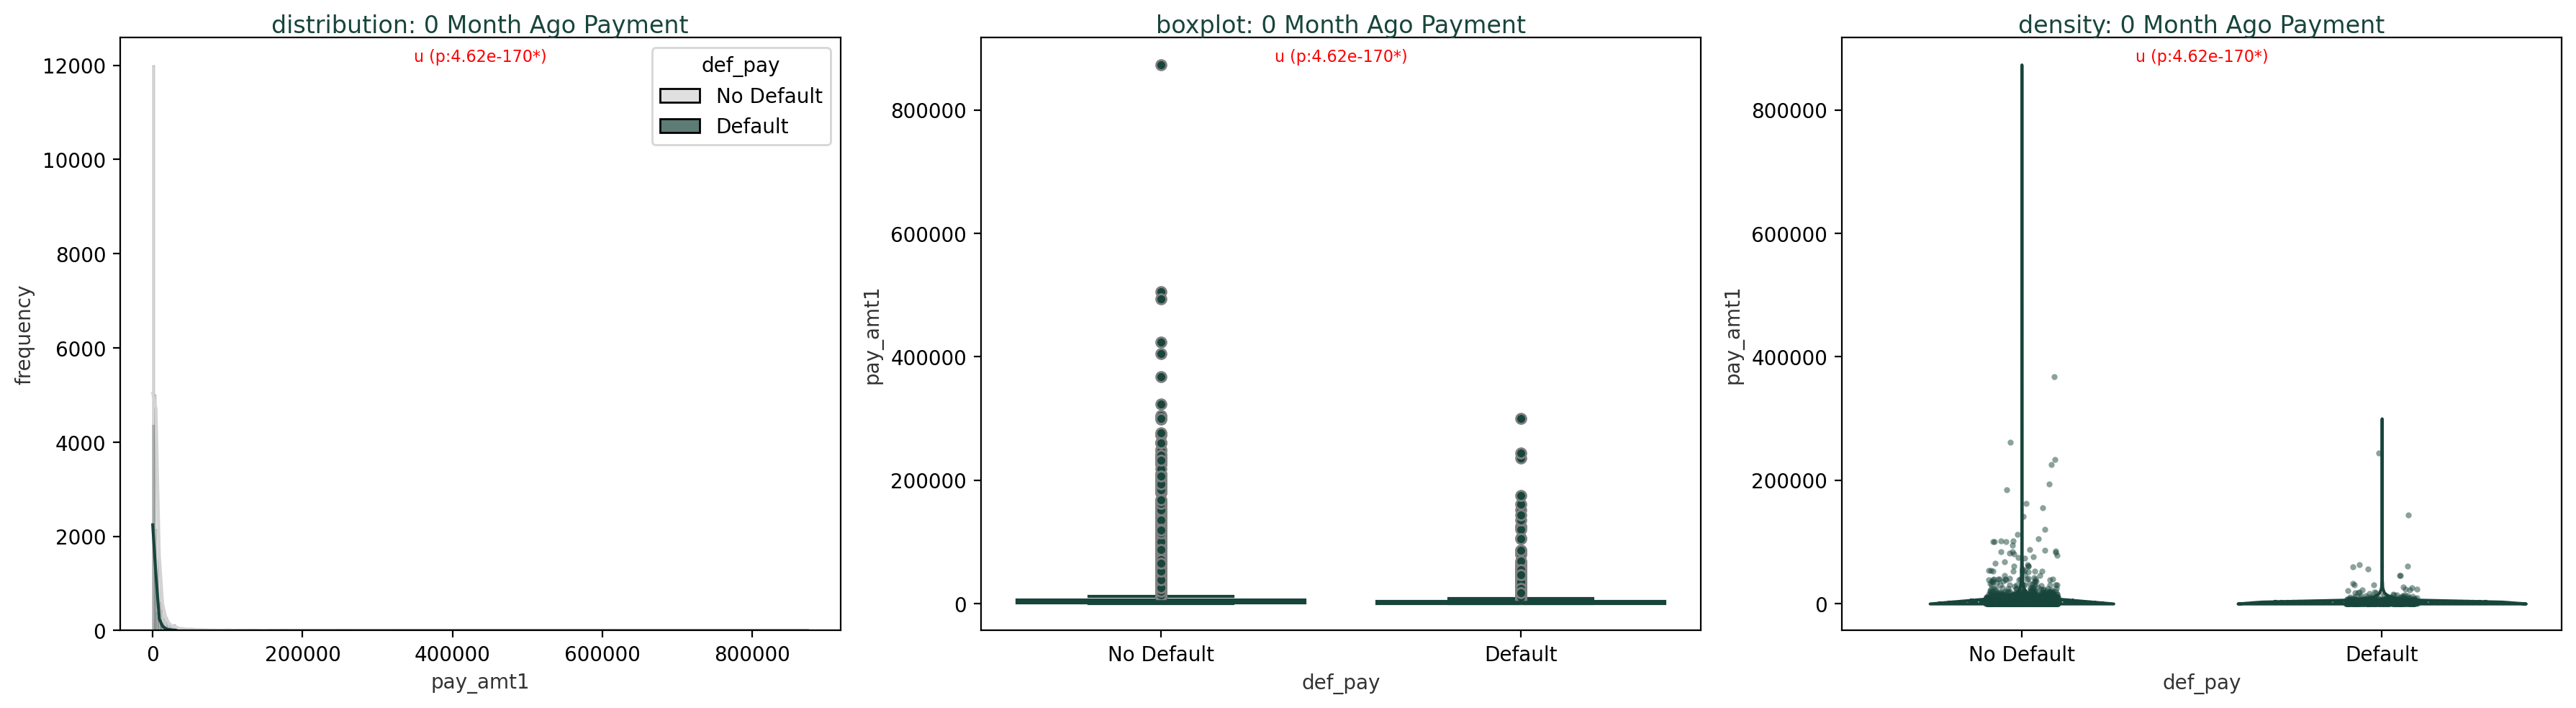

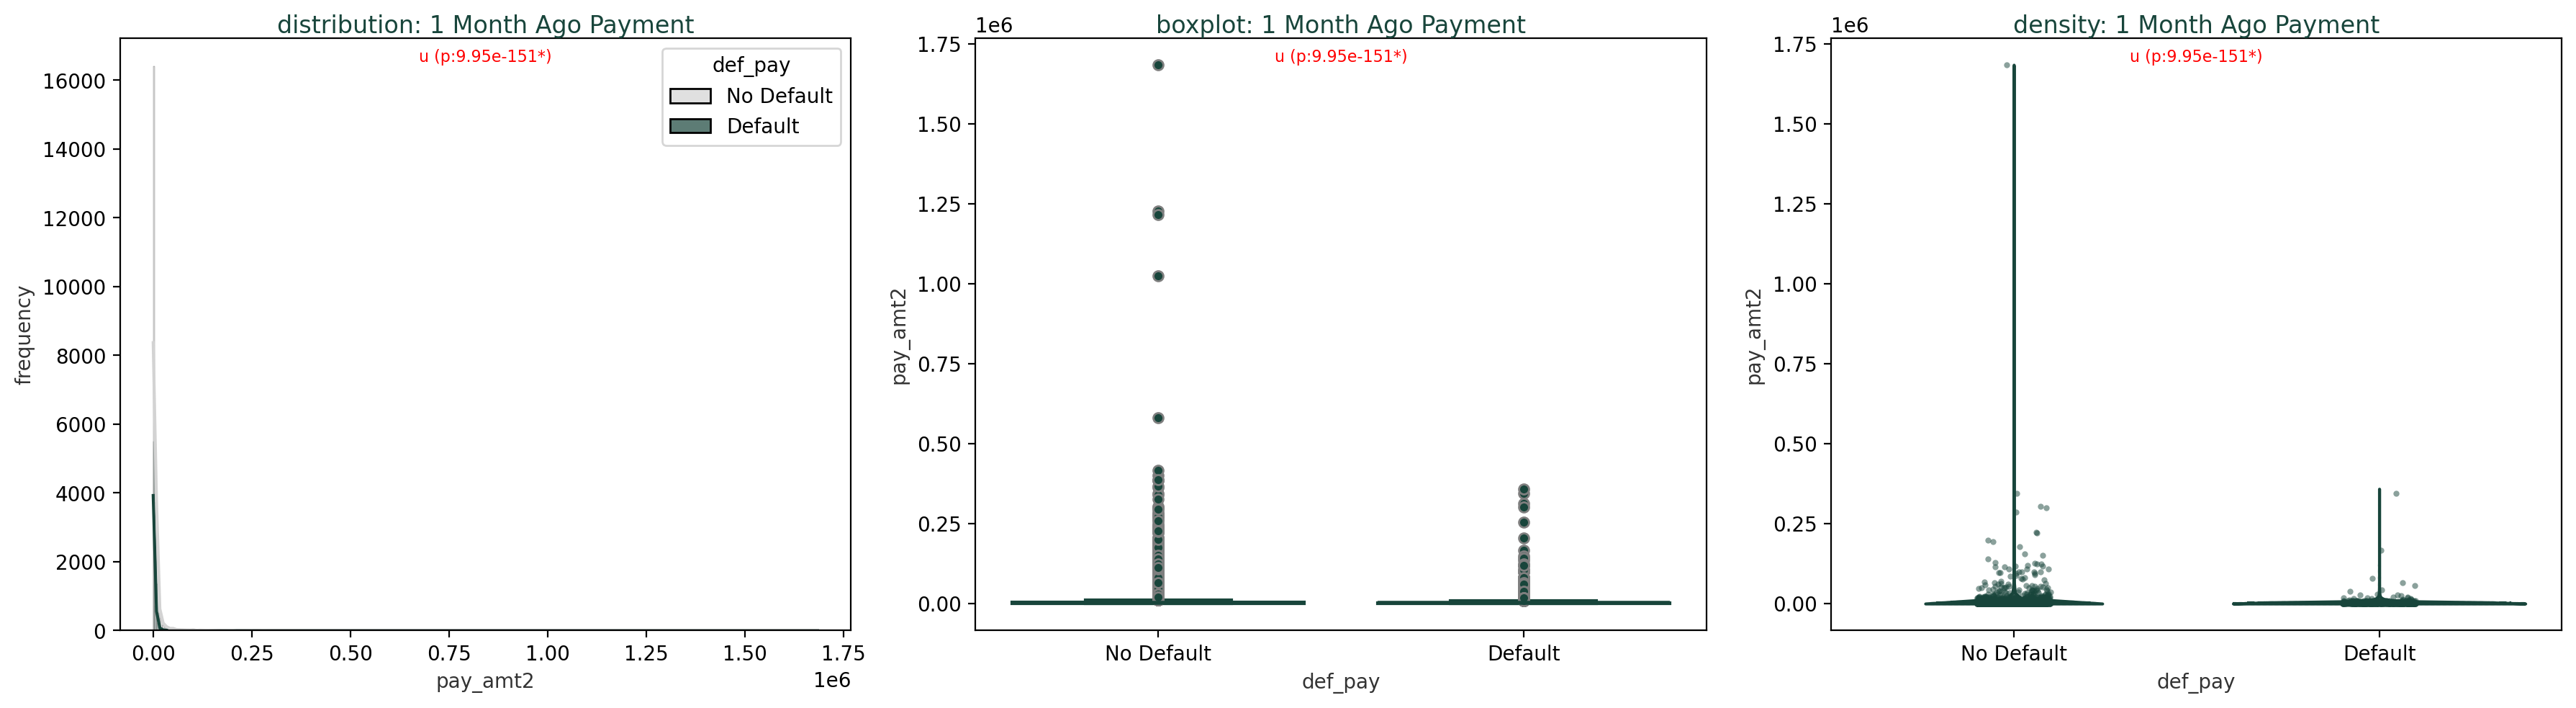

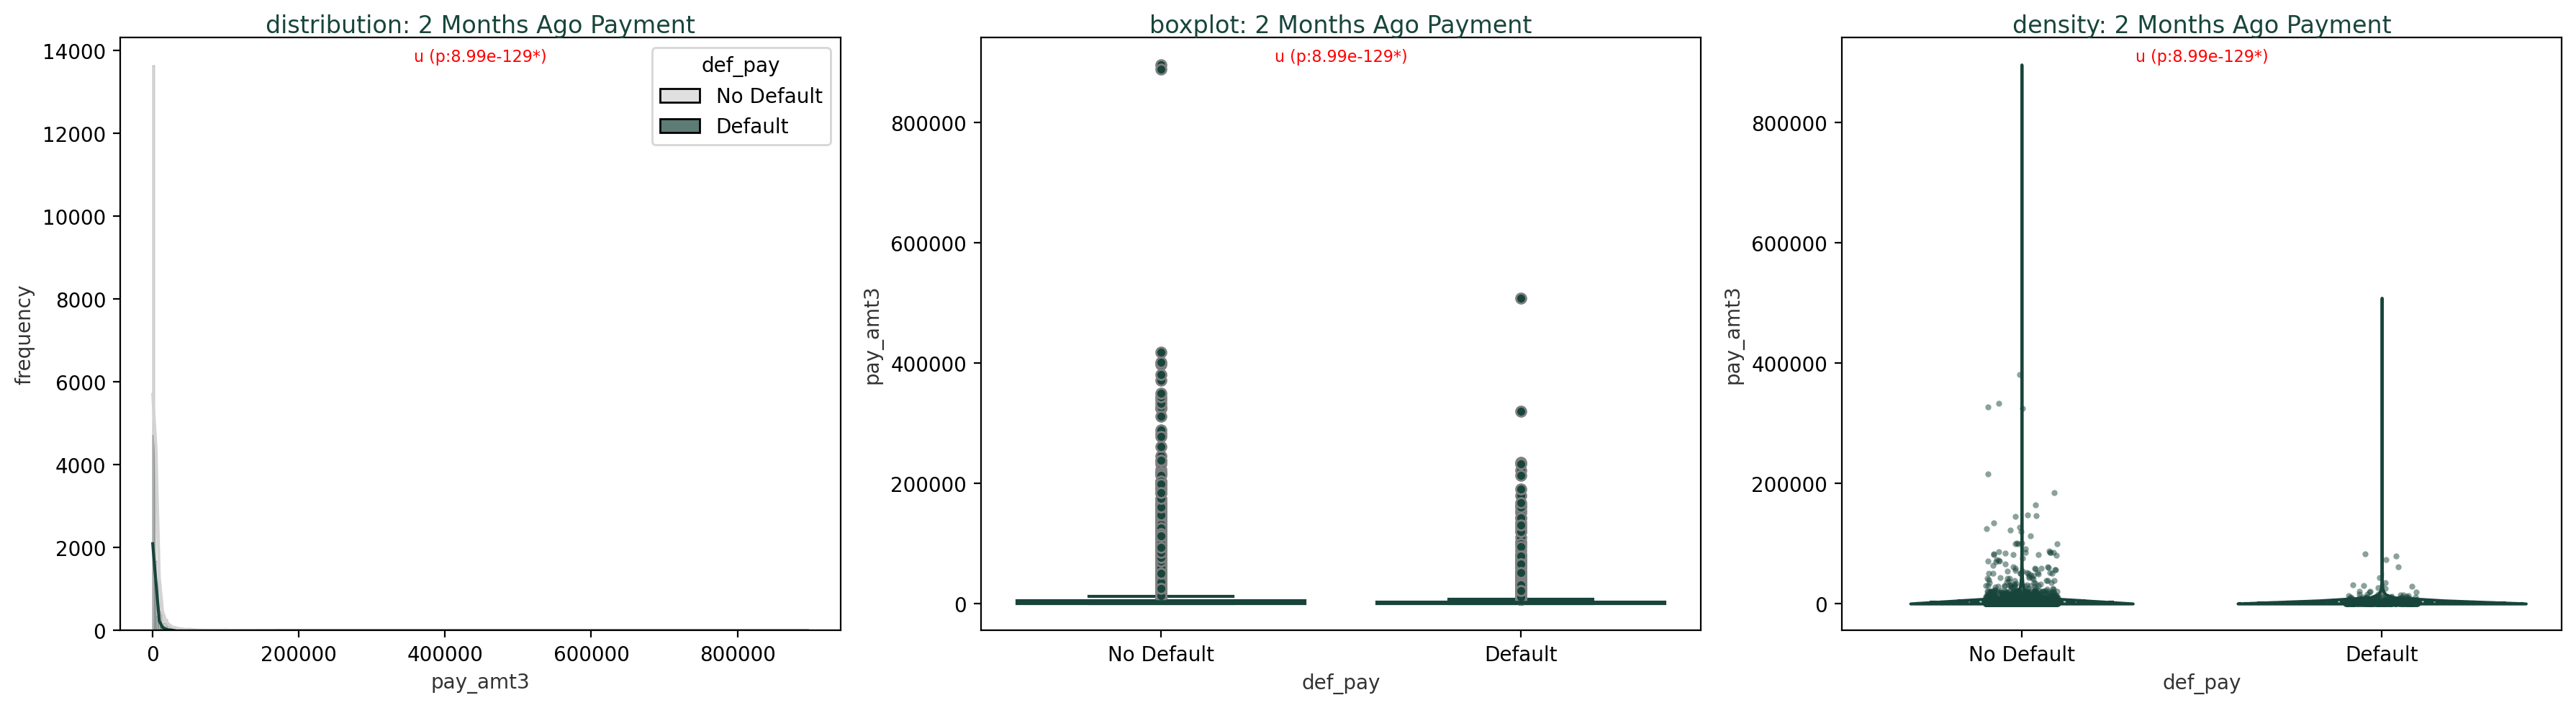

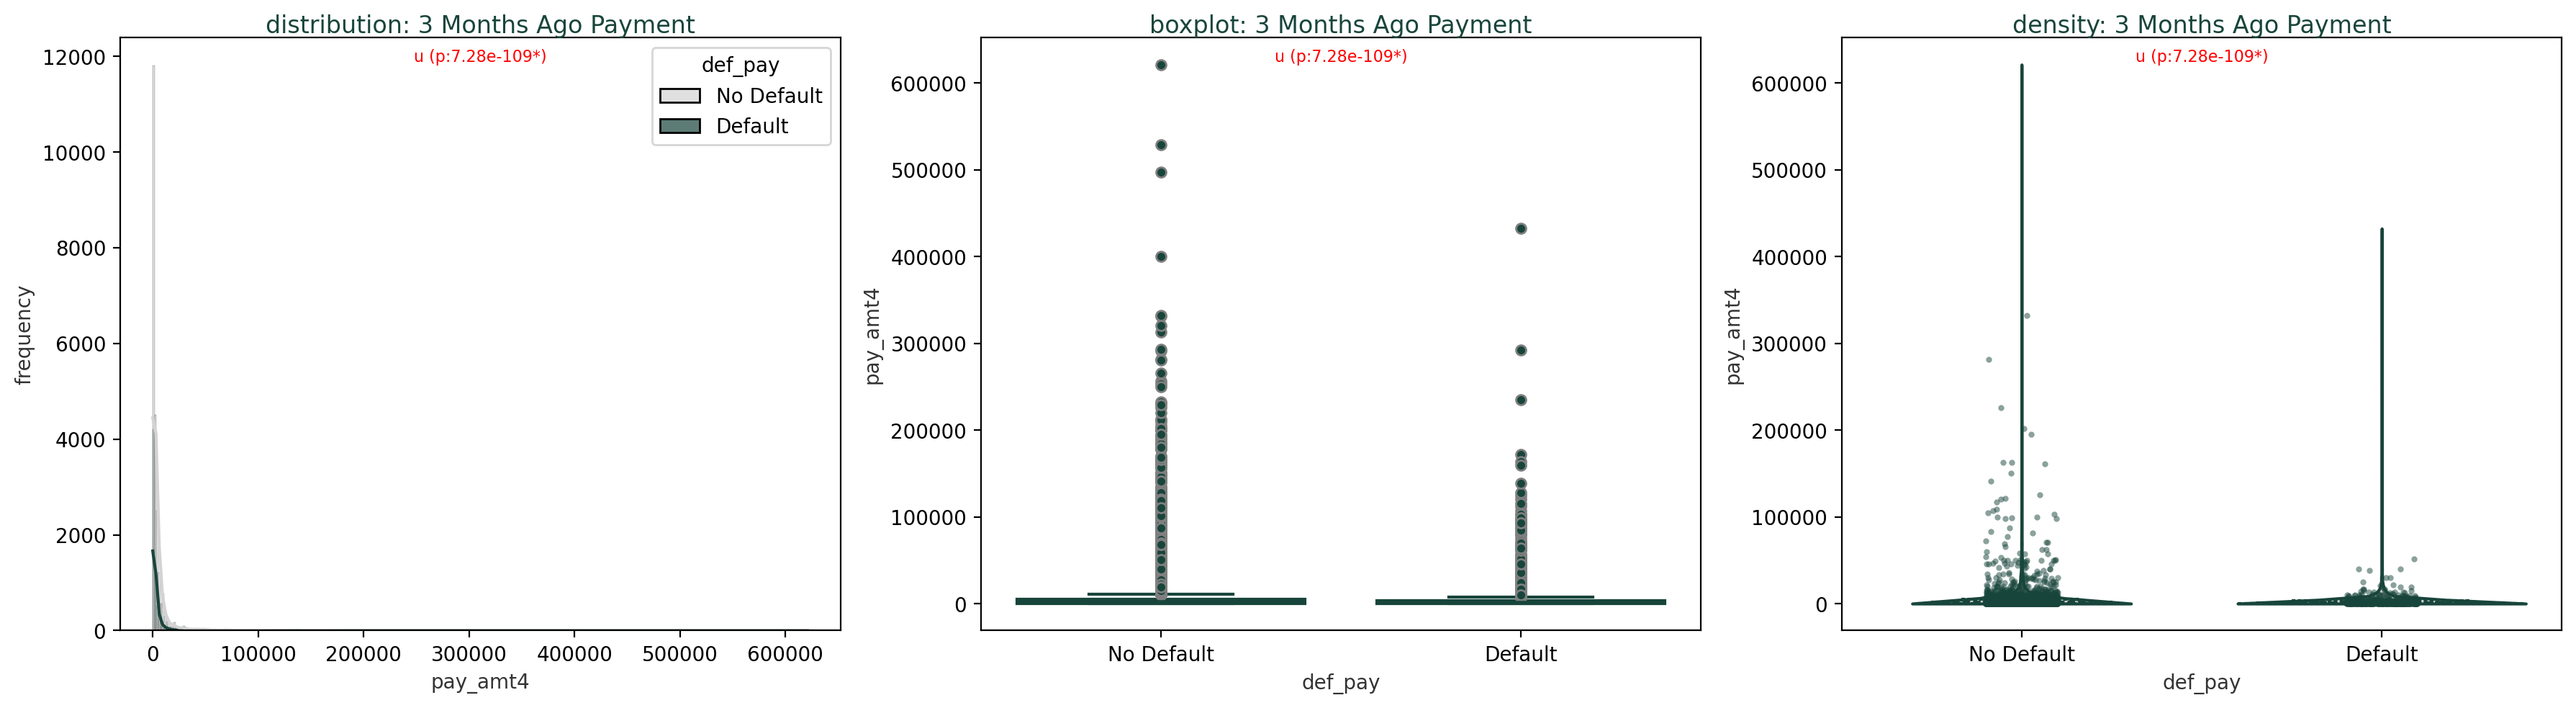

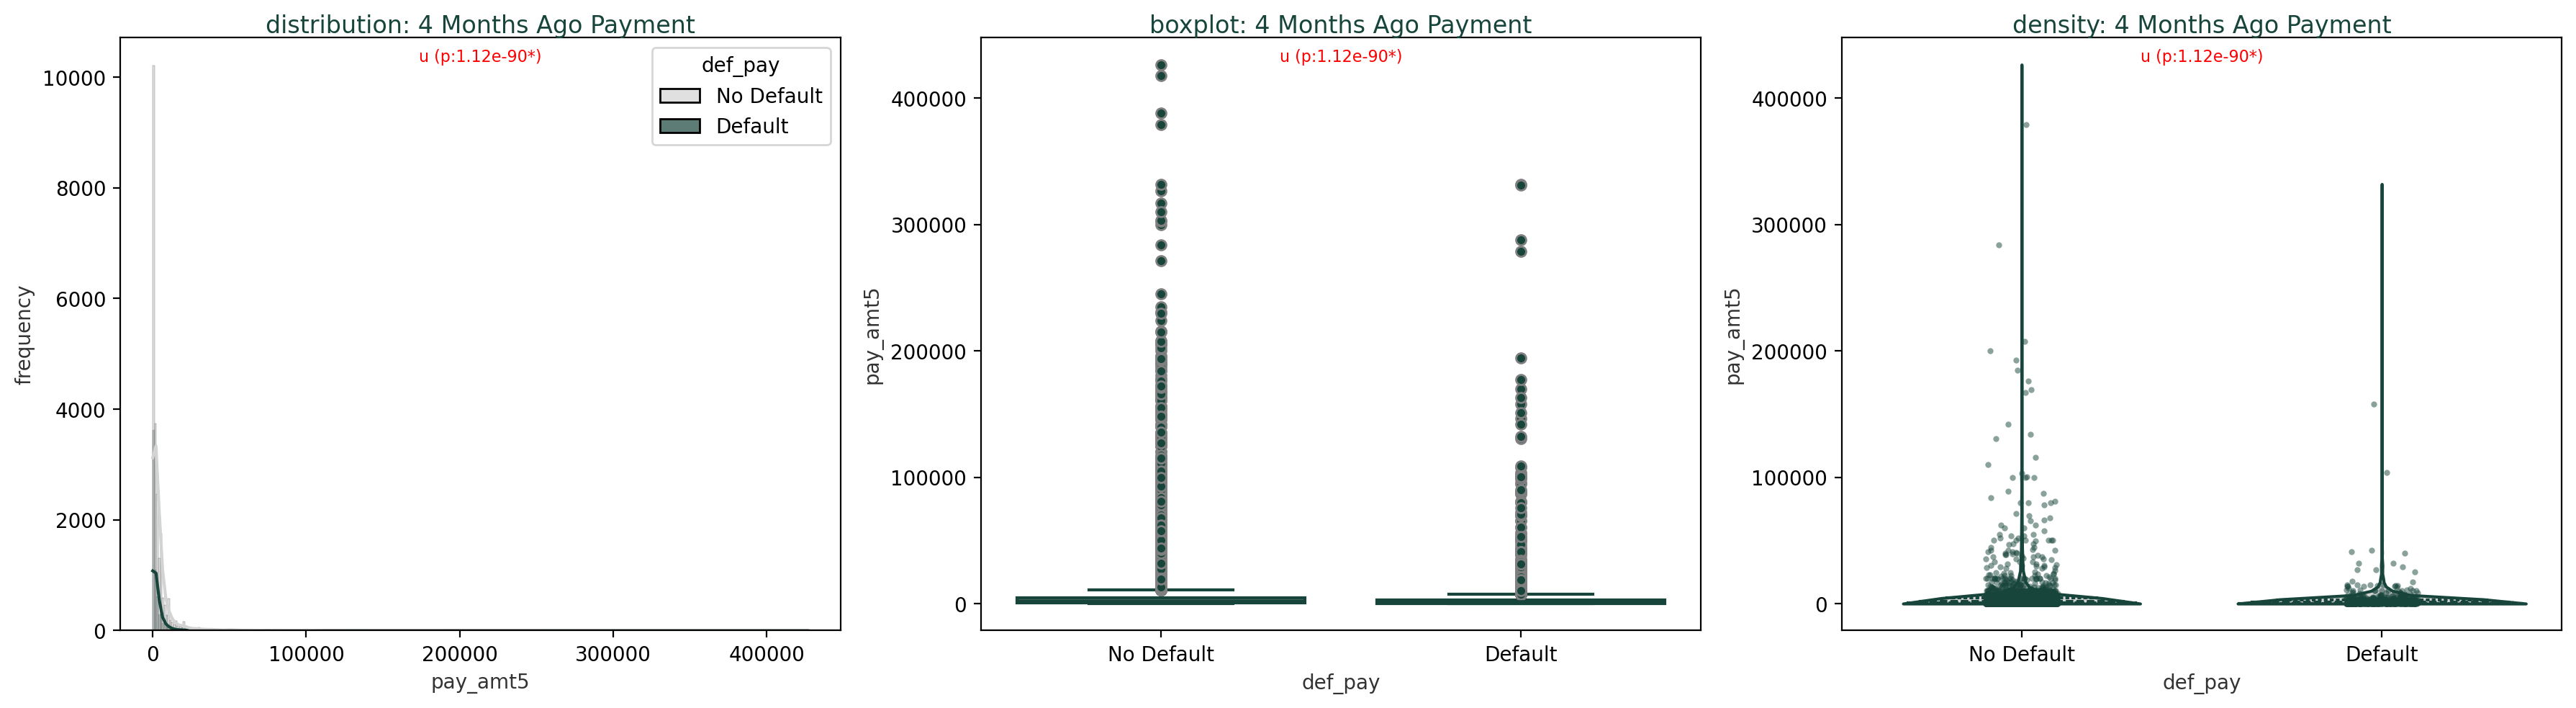

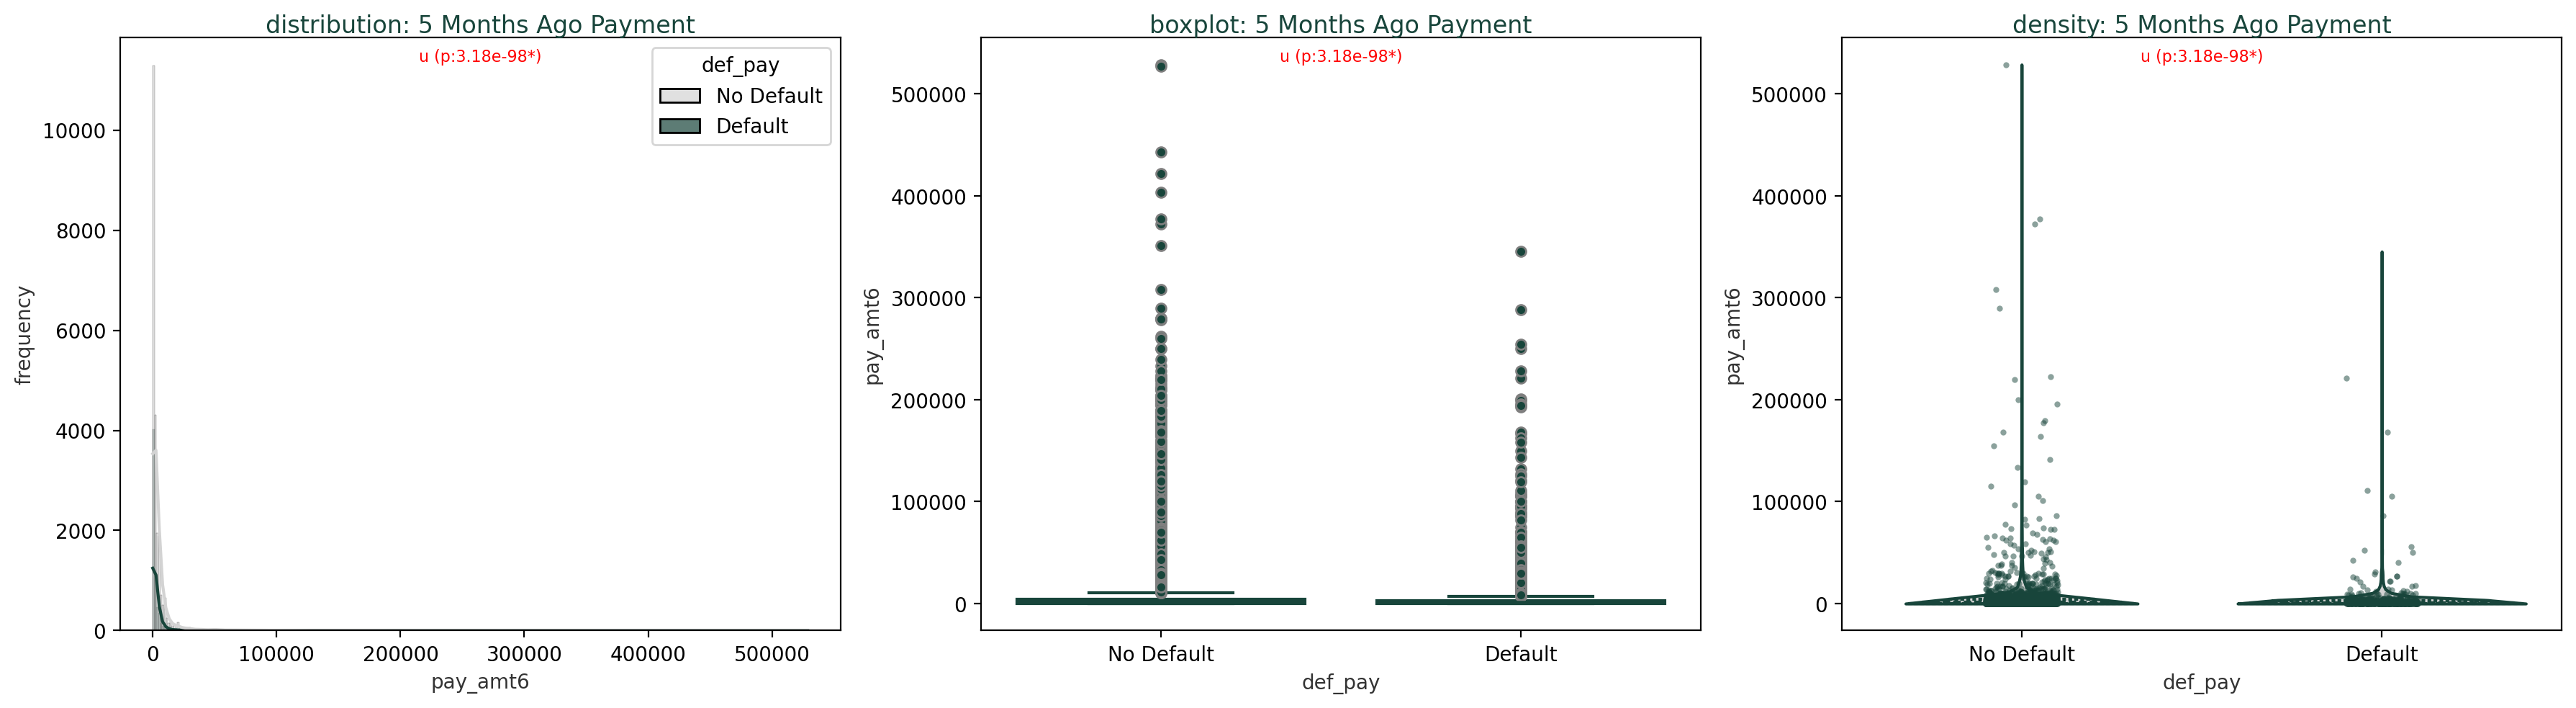

In [19]:
# numerical cols
p_values = {}
for col in numerical_cols:
    # check for missing values
    if X[col].isnull().any():
        missing_count = X[col].isnull().sum()
        missing_ratio = missing_count / len(X) * 100
        print(f"warning: {col} has {missing_count} missing values ({missing_ratio:.1f}%)")
    
    # create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1) histogram + kde
    sns.histplot(data=X, x=col, hue=y.map(mapping_dicts[target_col]), kde=True, ax=ax1, 
                 palette=msu_colors, alpha=0.7, bins='auto')
    ax1.set_title(f'distribution: {column_mapping[col]}', color=msu_colors[1], pad=0)
    ax1.set_xlabel(col, color='#333333')
    ax1.set_ylabel('frequency', color='#333333')
    
    # 2) boxplot
    sns.boxplot(data=X, x=y.map(mapping_dicts[target_col]), y=col, ax=ax2, 
                boxprops=dict(facecolor=msu_colors[0], edgecolor=msu_colors[1], linewidth=1.5), # box
                medianprops=dict(color=msu_colors[1], linewidth=2),
                whiskerprops=dict(color=msu_colors[1], linewidth=1.5),
                capprops=dict(color=msu_colors[1], linewidth=1.5),
                flierprops=dict(markerfacecolor=msu_colors[1], markersize=5)) # flier/ball
    ax2.set_title(f'boxplot: {column_mapping[col]}', color=msu_colors[1], pad=0)
    ax2.set_xlabel(target_col, color='#333333')
    ax2.set_ylabel(col, color='#333333')
    
    # 3) violin + stripplot (instead of swarmplot; to reduce overlap)
    # violinplot
    sns.violinplot(data=X, x=y.map(mapping_dicts[target_col]), y=col, ax=ax3,
                   color=msu_colors[0], inner='quartile',
                   linecolor=msu_colors[1], linewidth=1.5, cut=0)
    # sample stripplot for large datasets
    sample_data = X.sample(frac=0.1, random_state=SEED) if len(X) > 1000 else X # if >1000 rows 10% sampling, alpha=0.5
    sns.stripplot(data=sample_data, x=y.map(mapping_dicts[target_col]), y=col, ax=ax3,
                  color=msu_colors[1], size=3, alpha=0.5, jitter=True)
    ax3.set_title(f'density: {column_mapping[col]}', color=msu_colors[1], pad=0)
    ax3.set_xlabel(target_col, color='#333333')
    ax3.set_ylabel(col, color='#333333')
    
    # t-test or mann-whitney u test
    group1 = X[y == 1][col]
    group0 = X[y == 0][col]
    try:
        # sample for shapiro test to avoid large N warning
        sample_size = min(1000, len(group1), len(group0))
        group1_sample = group1.sample(n=sample_size, random_state=SEED) if len(group1) > sample_size else group1
        group0_sample = group0.sample(n=sample_size, random_state=SEED) if len(group0) > sample_size else group0
        # check normality of class 1 and 0 with shapiro-wilk test
        _, p_norm1 = shapiro(group1_sample)
        _, p_norm0 = shapiro(group0_sample)
        is_normal = p_norm1 > 0.05 and p_norm0 > 0.05 # normal if p > 0.05
        # if normal: Welch's t-test, if non-normal: Mann-Whitney U
        if is_normal:
            # use t-test for normal data
            t_stat, p_val = ttest_ind(group1, group0, equal_var=False) # equal_var=False -> Welch’s t-test
            test_stat = t_stat
            test_name = 't'
        else:
            # use mann-whitney u for non-normal data
            _, p_val = mannwhitneyu(group1, group0, alternative='two-sided')
            test_stat = None
            test_name = 'u'
            
    except Exception as e: # ValueError --> Exception
        print(f"error: statistical test failed for {col}: {e}")
        p_val = 1.0
        test_stat = 0.0
        test_name = 't'
        # test_stat = None
        # test_name = 'skip'
        # continue

    p_values[col] = p_val
    
    # annotate statistical test result
    # if significant difference (p<0.05), highlihght it red
    p_text = f'{test_name}:{test_stat:.2f} (p:{p_val:.2e}' + ('*)' if p_val < 0.05 else ')') if test_name == 't' else f'{test_name} (p:{p_val:.2e}' + ('*)' if p_val < 0.05 else ')')
    for ax in [ax1, ax2, ax3]:
        ax.text(
            0.5, 0.96, p_text,
            transform=ax.transAxes,
            color='red' if p_val < 0.05 else '#909090',
            ha='center', fontsize=8
        )
    
    plt.tight_layout()
    plt.show()

In [20]:
# feature importance
sorted_p = sorted(p_values.items(), key=lambda x: x[1])
for col, p in sorted_p[:10]:
    # top 10 features
    print(f"{col:20} p={p:.2e} {'★' if p<0.05 else ''}")

limit_bal            p=1.23e-189 ★
pay_amt1             p=4.62e-170 ★
pay_amt2             p=9.95e-151 ★
pay_amt3             p=8.99e-129 ★
pay_amt4             p=7.28e-109 ★
pay_amt6             p=3.18e-98 ★
pay_amt5             p=1.12e-90 ★
bill_amt1            p=1.15e-05 ★
bill_amt2            p=7.06e-03 ★
bill_amt3            p=2.82e-02 ★


- lower credit limit --> much higher default risk
    - p = 1.23e-189, strongest signal
- lower recent payments --> much higher default risk
    - pay_amt1-6 all p < 1e-90, top 7 features
- lower recent bills --> slightly higher default risk
    - bill_amt1-3 significant, bill_amt4-6 not

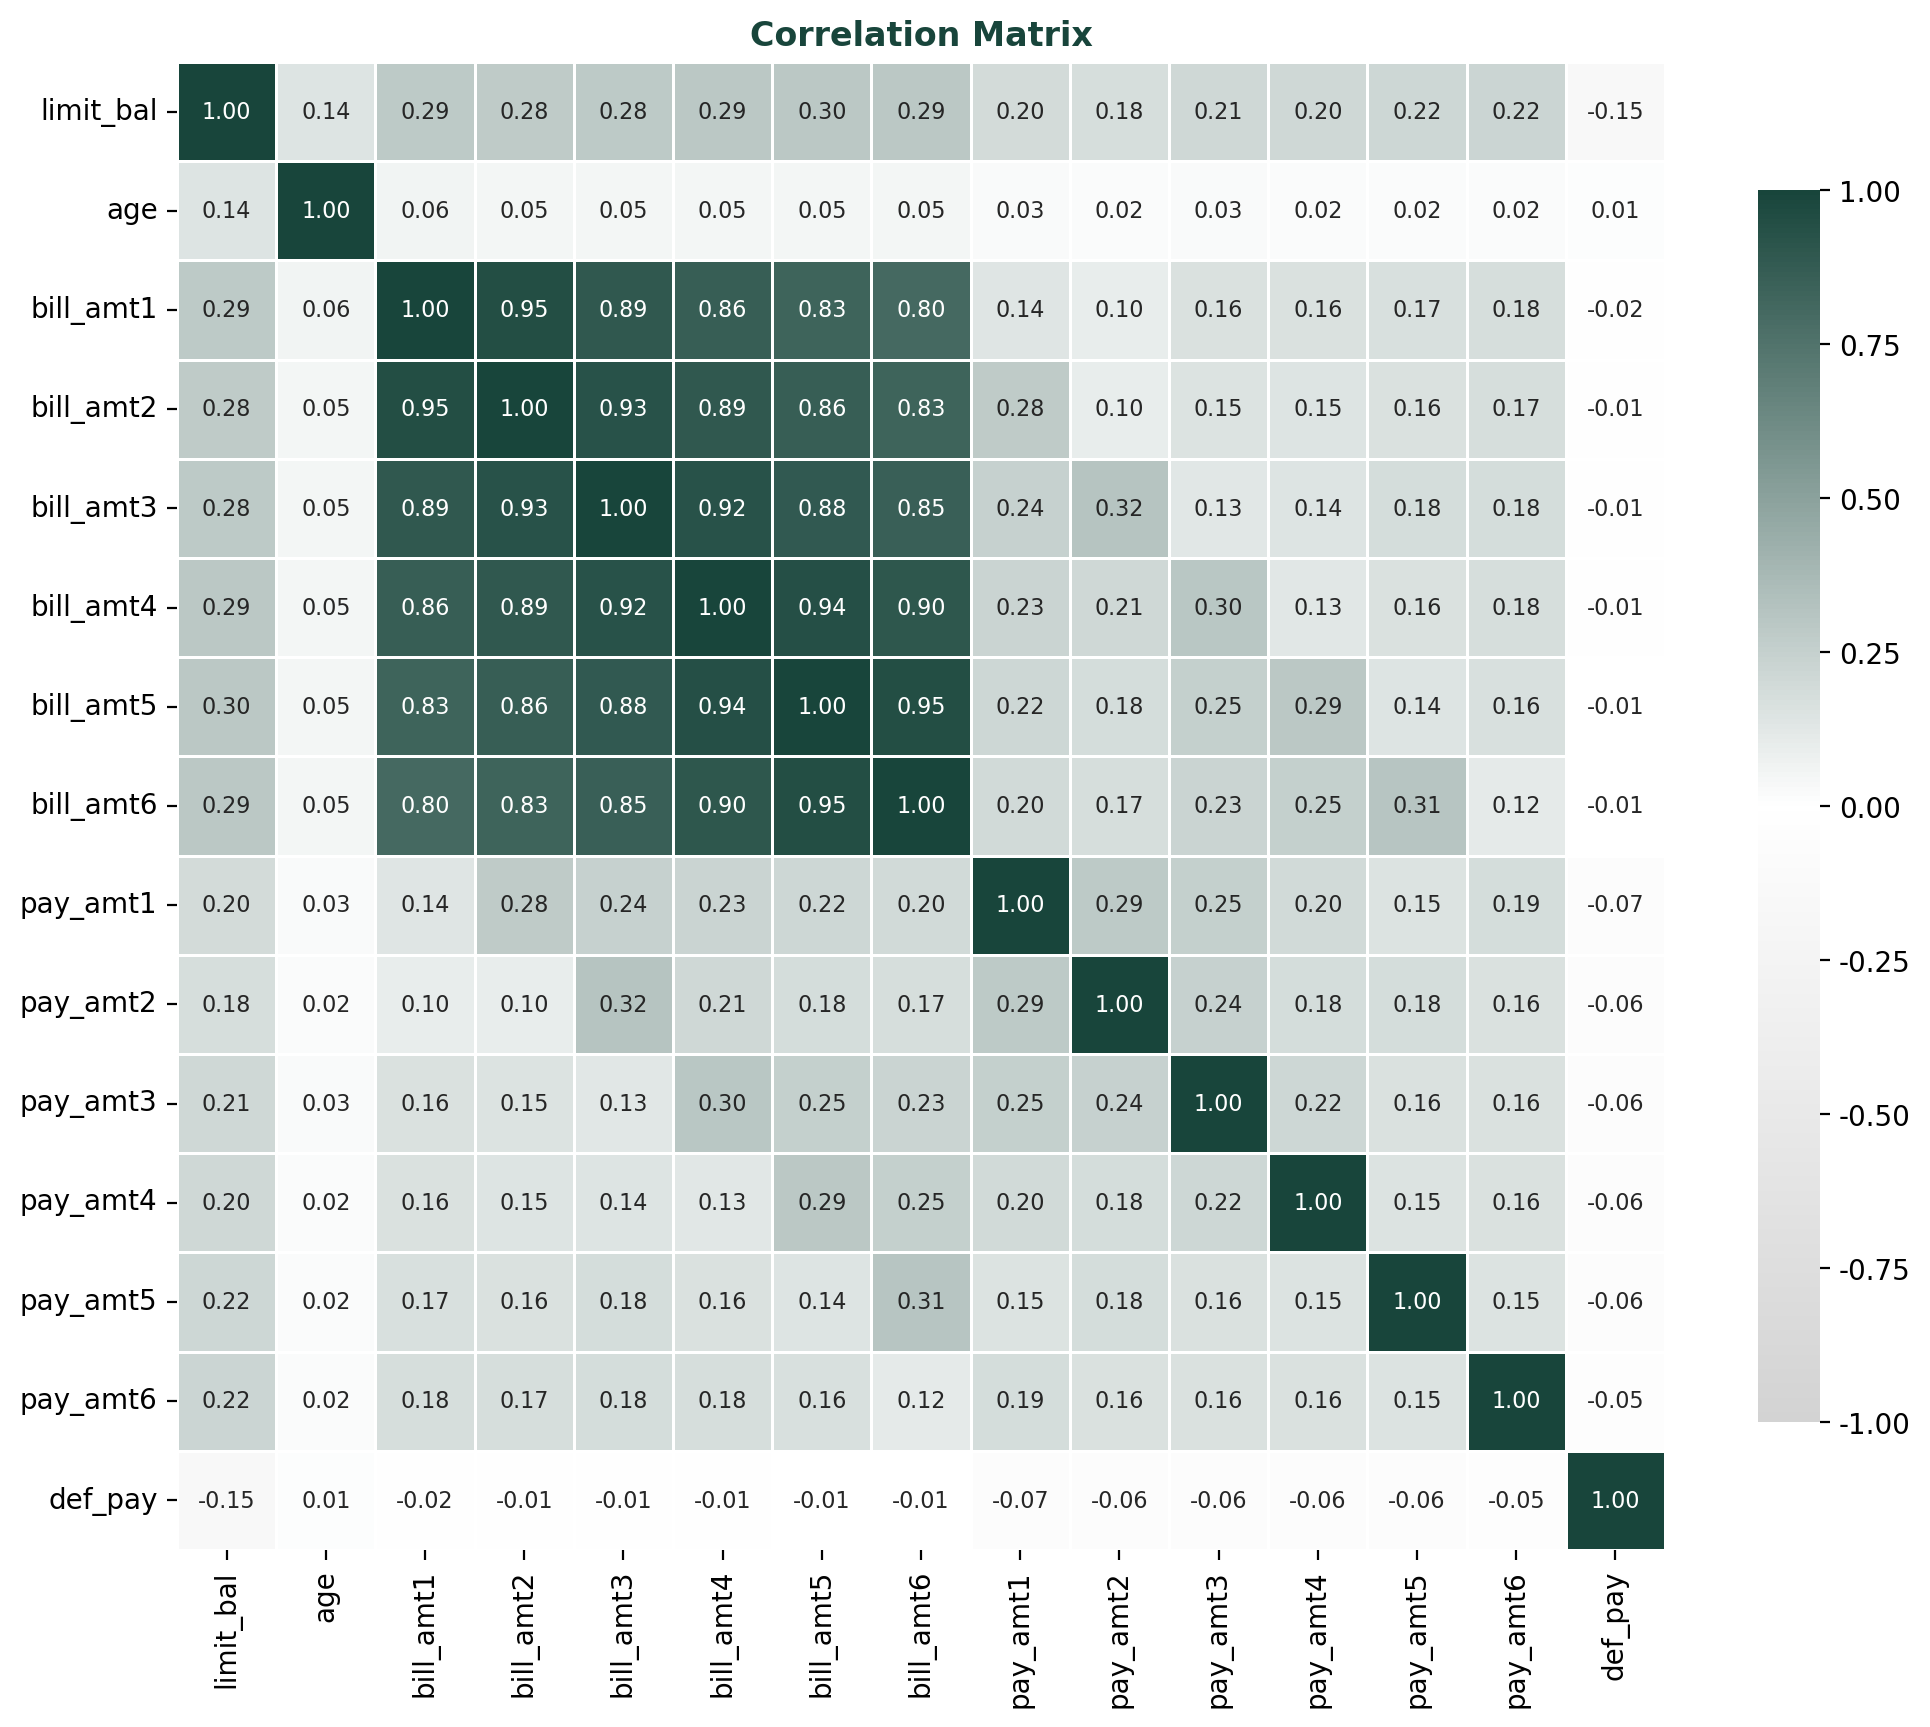

In [21]:
# correlation (numeric)

plt.figure(figsize=(12, 10), facecolor='white')
corr = pd.concat([X[numerical_cols], y], axis=1).corr()

# set color map: spartan green --> white --> light gray
colors = [msu_colors[0], '#FFFFFF', msu_colors[1]]
# msu_cmap = sns.light_palette('#18453B', as_cmap=True)
# msu_cmap = sns.color_palette(colors, as_cmap=True)
msu_cmap = LinearSegmentedColormap.from_list('msu_cmap', colors, N=256)

sns.heatmap(corr, annot=True, cmap=msu_cmap, fmt='.2f', 
            linewidths=0.5, vmin=-1, vmax=1, center=0, #linecolor='#18453B', 
            square=True, cbar_kws={'shrink': 0.8}, annot_kws={'fontsize':8})
plt.title('Correlation Matrix', fontweight='bold', color=msu_colors[1])
plt.show()

- bill amount features correlated with each other
- no highly correlated features with target

In [22]:
# t-test (numeric)
ttest_results = []
for col in numerical_cols:
    group1 = X[y == 1][col].dropna()
    group0 = X[y == 0][col].dropna()
    t_stat, p_val = ttest_ind(group1, group0)
    ttest_results.append([col, t_stat, p_val])
ttest_df = pd.DataFrame(ttest_results, columns=['Feature', 't-statistic', 'p-value'])

# result table color setting
threshold = 0.05
def color_pval(val):
    color = '#18453B' if val < threshold else 'gray'
    return f'color: {color}'
styled_ttest = ttest_df.sort_values('p-value').style.map(color_pval, subset=['p-value'])
styled_ttest.set_caption('T-test Results (Green = p < 0.05)')
styled_ttest

- higher limit and higher payments = clear sign of safe clients
    - t-stats negative and huge
- --> defaulters pay less and get less credit

In [23]:
# VIF (numeric)
vif_cols = numerical_cols
vif_data = pd.DataFrame({
    'Feature': vif_cols,
    'VIF': [variance_inflation_factor(X[vif_cols].values, i) for i in range(len(vif_cols))]
})

# VIF result color setting
threshold = 10
def color_vif(val):
    color = '#18453B' if val > threshold else 'gray' # VIF > threshold: green, else: gray
    return f'color: {color}'
styled_vif = vif_data.sort_values('VIF', ascending=False).style.map(color_vif, subset=['VIF'])
styled_vif.set_caption(f'VIF Scores (Green = VIF > {threshold})')
styled_vif

- multicolinearity among bill amount features
- rather than removing the bill amount variables, we could convert them --> differencing, average, PCA, or interaction with pay amount features

## Categorical

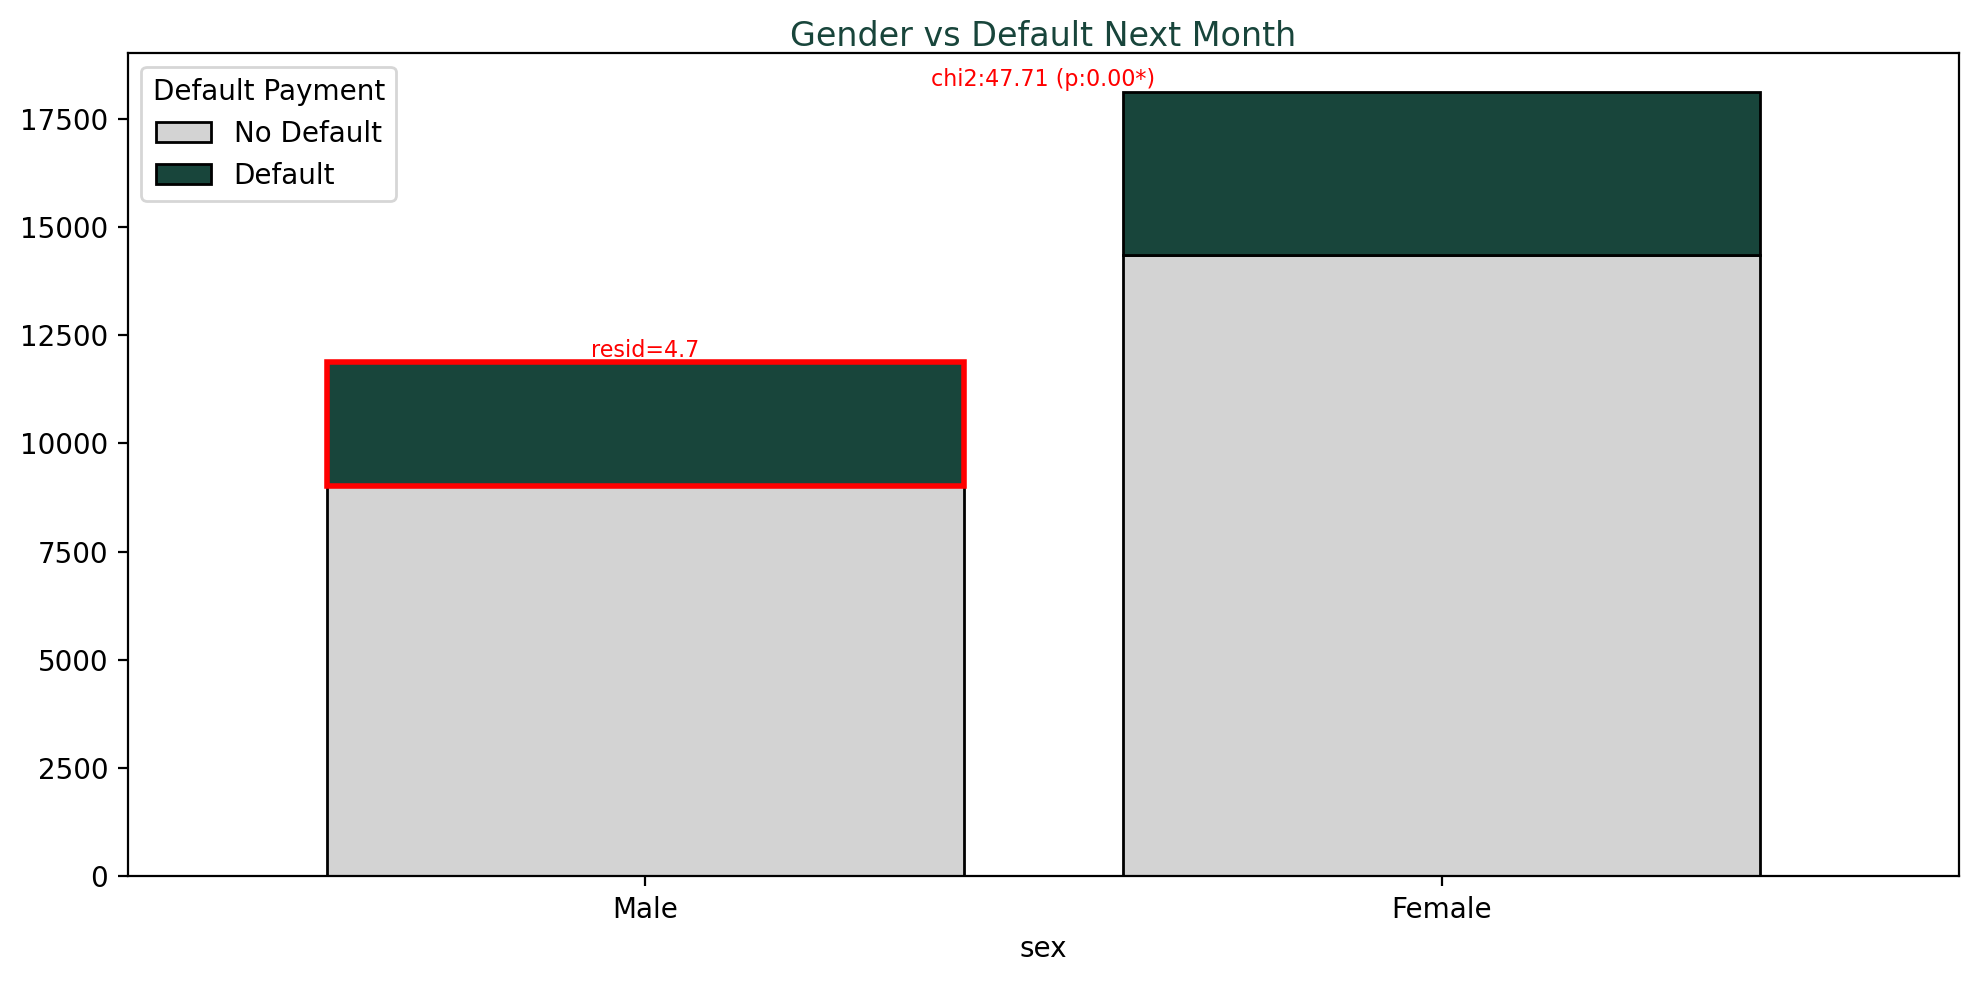

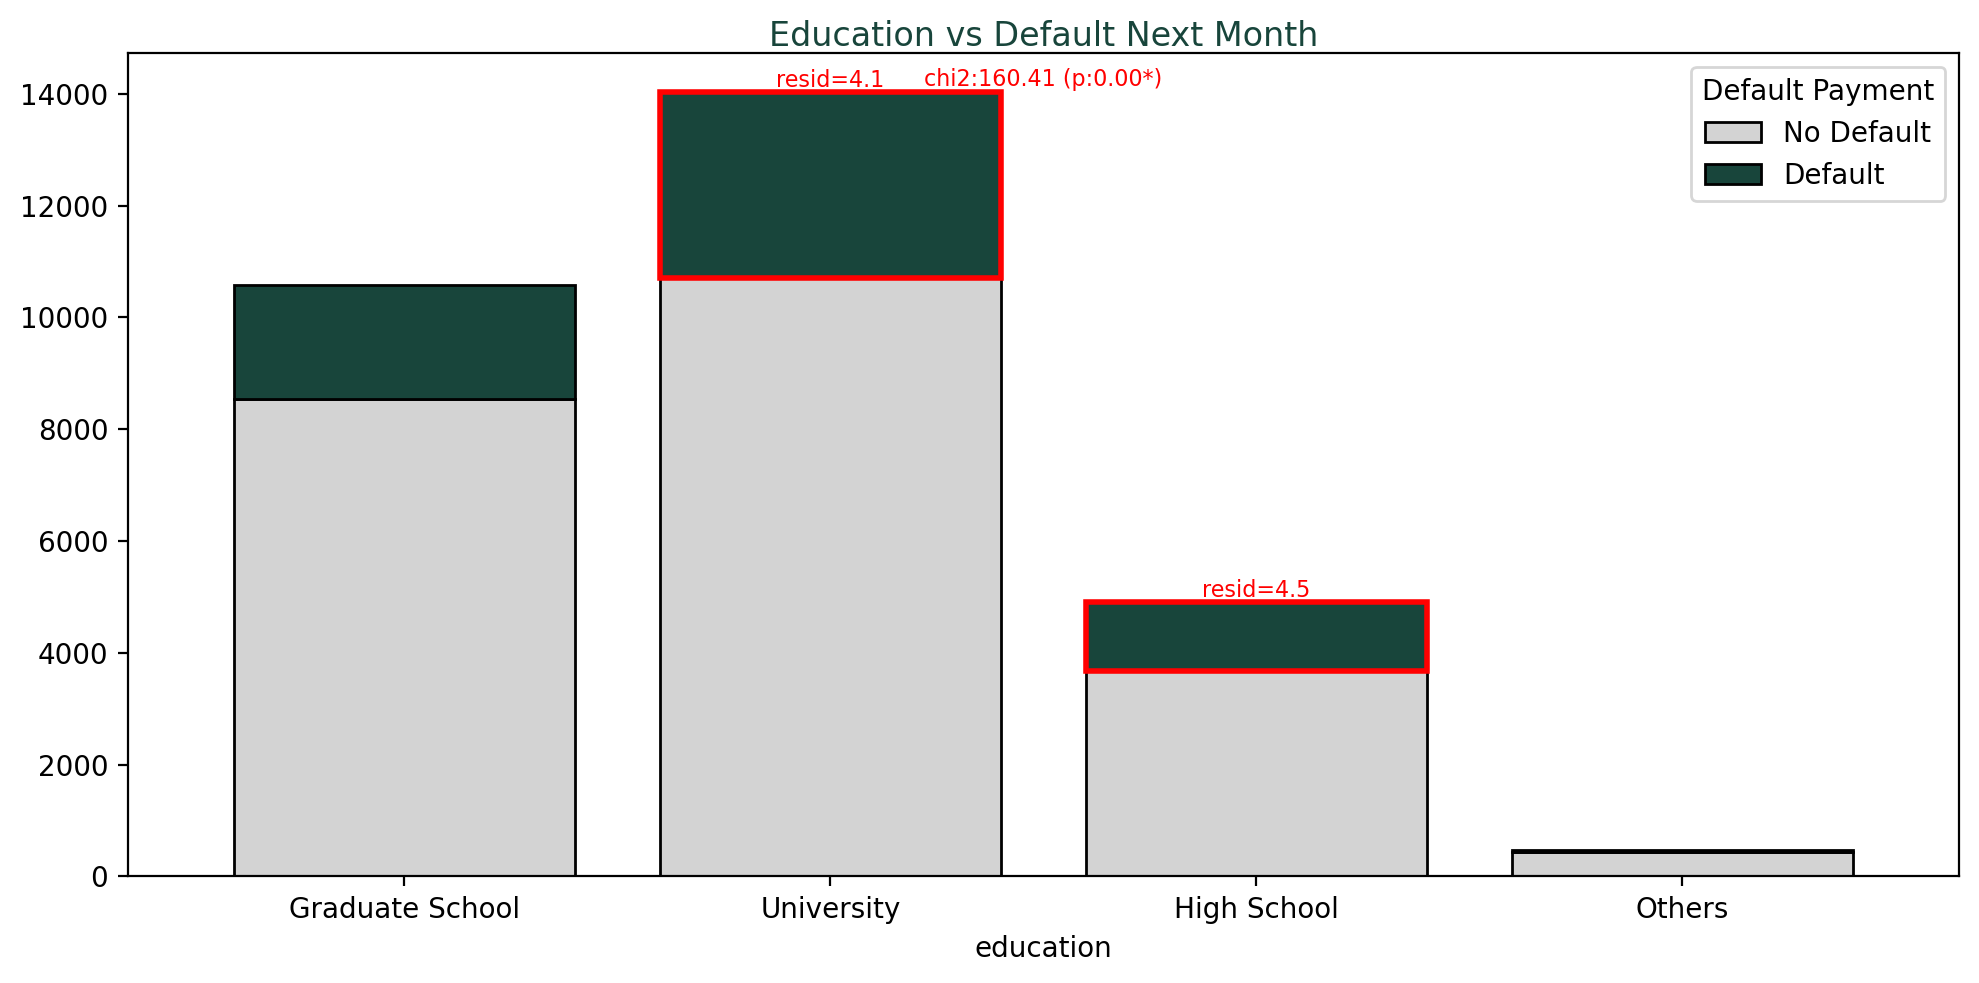

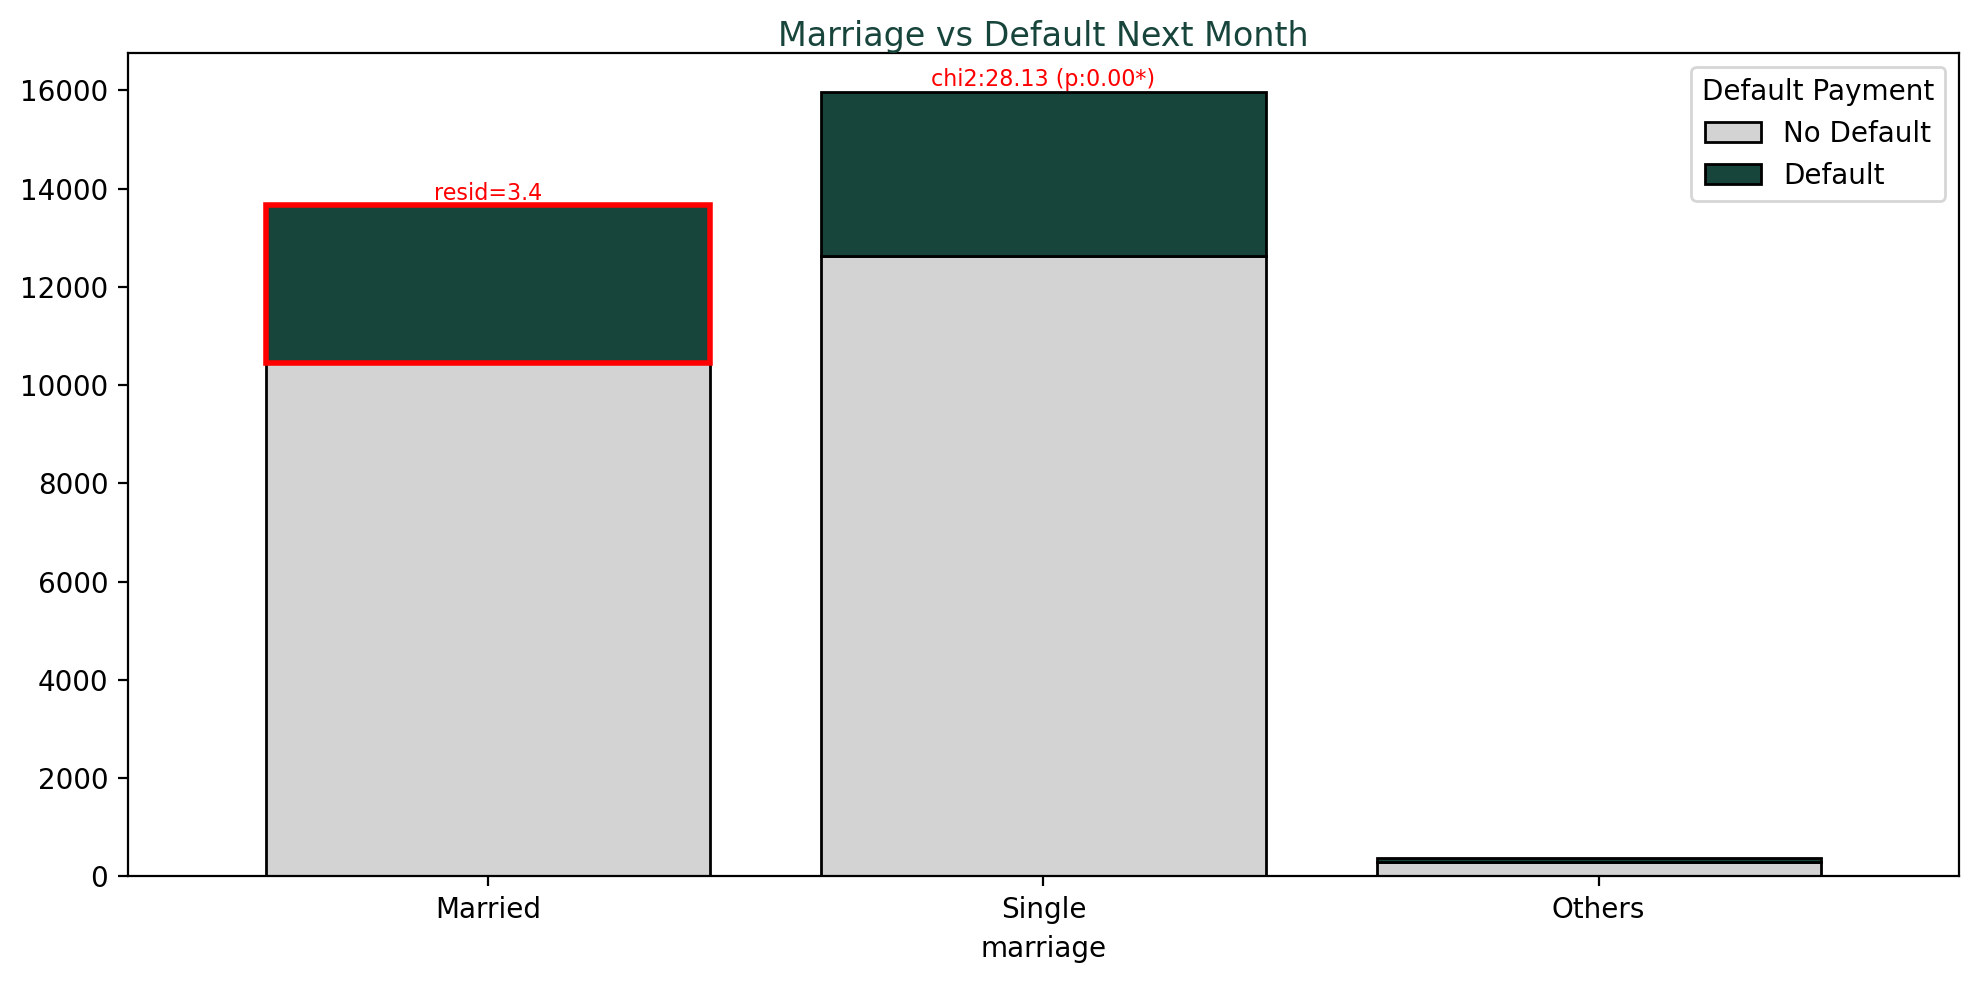

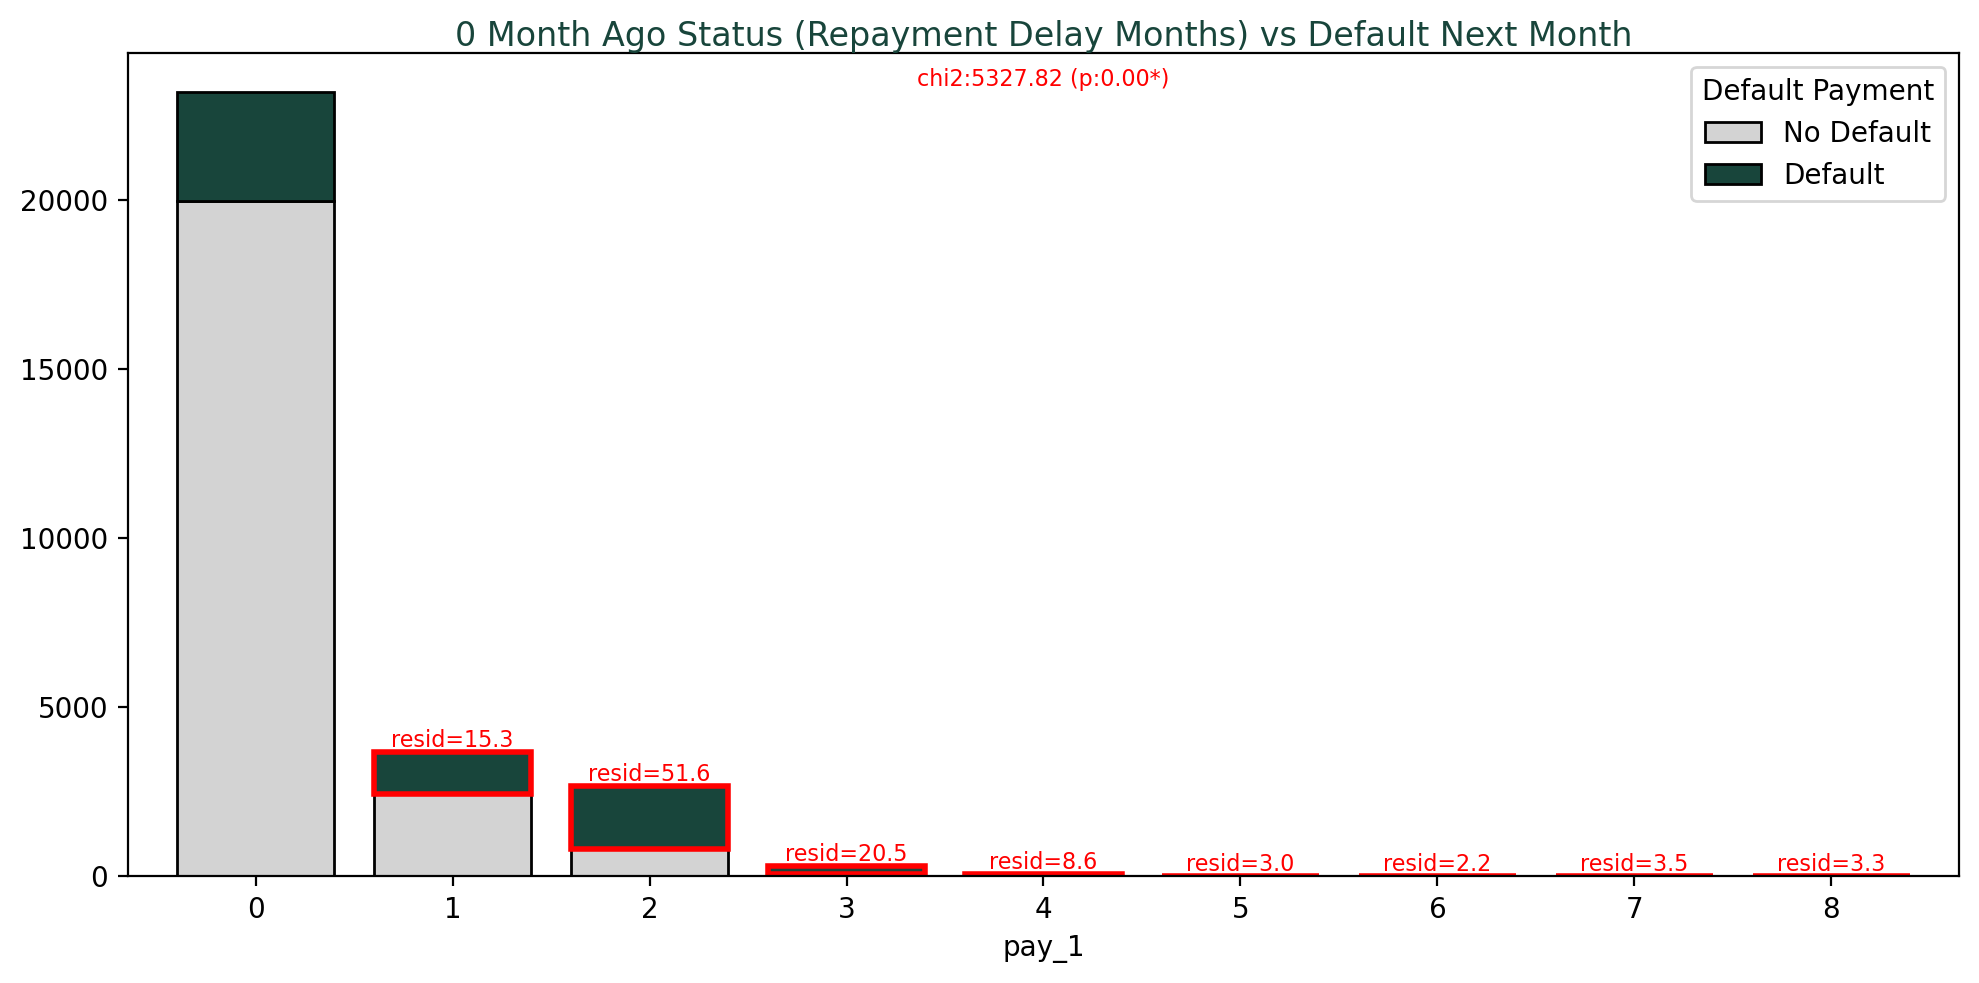

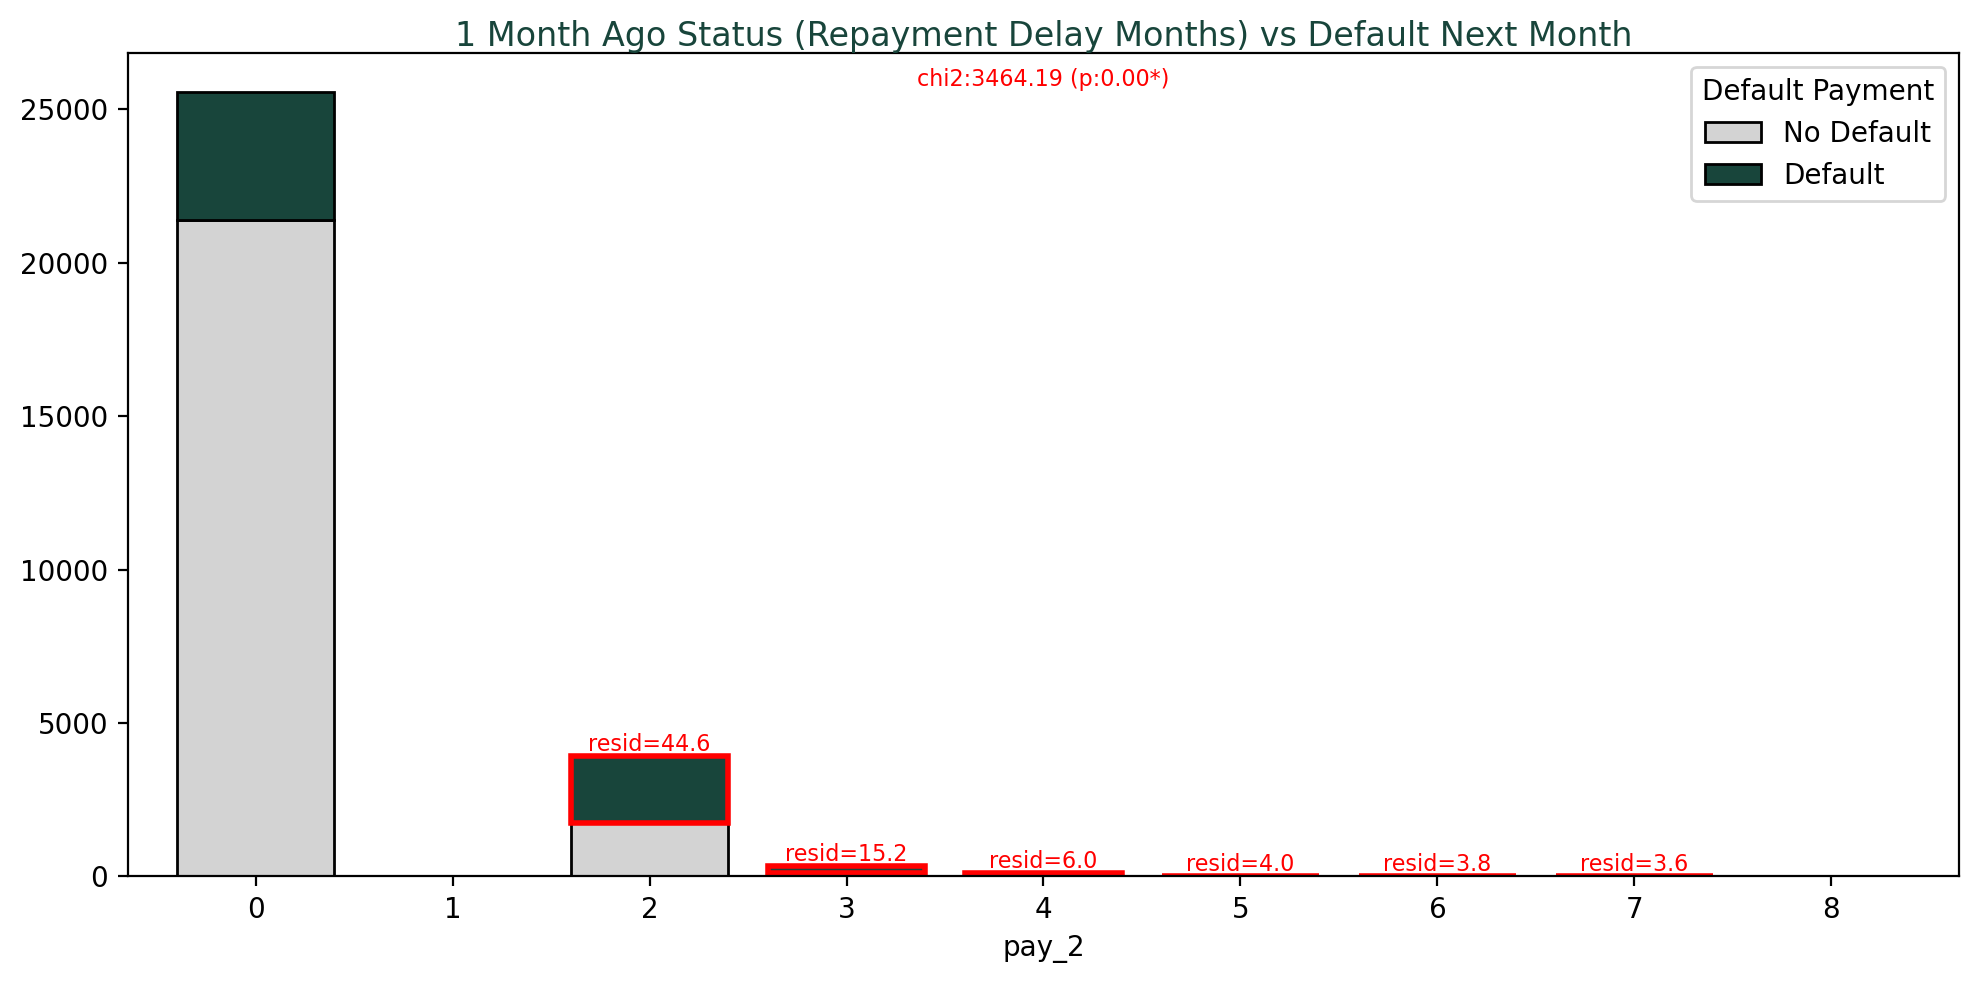

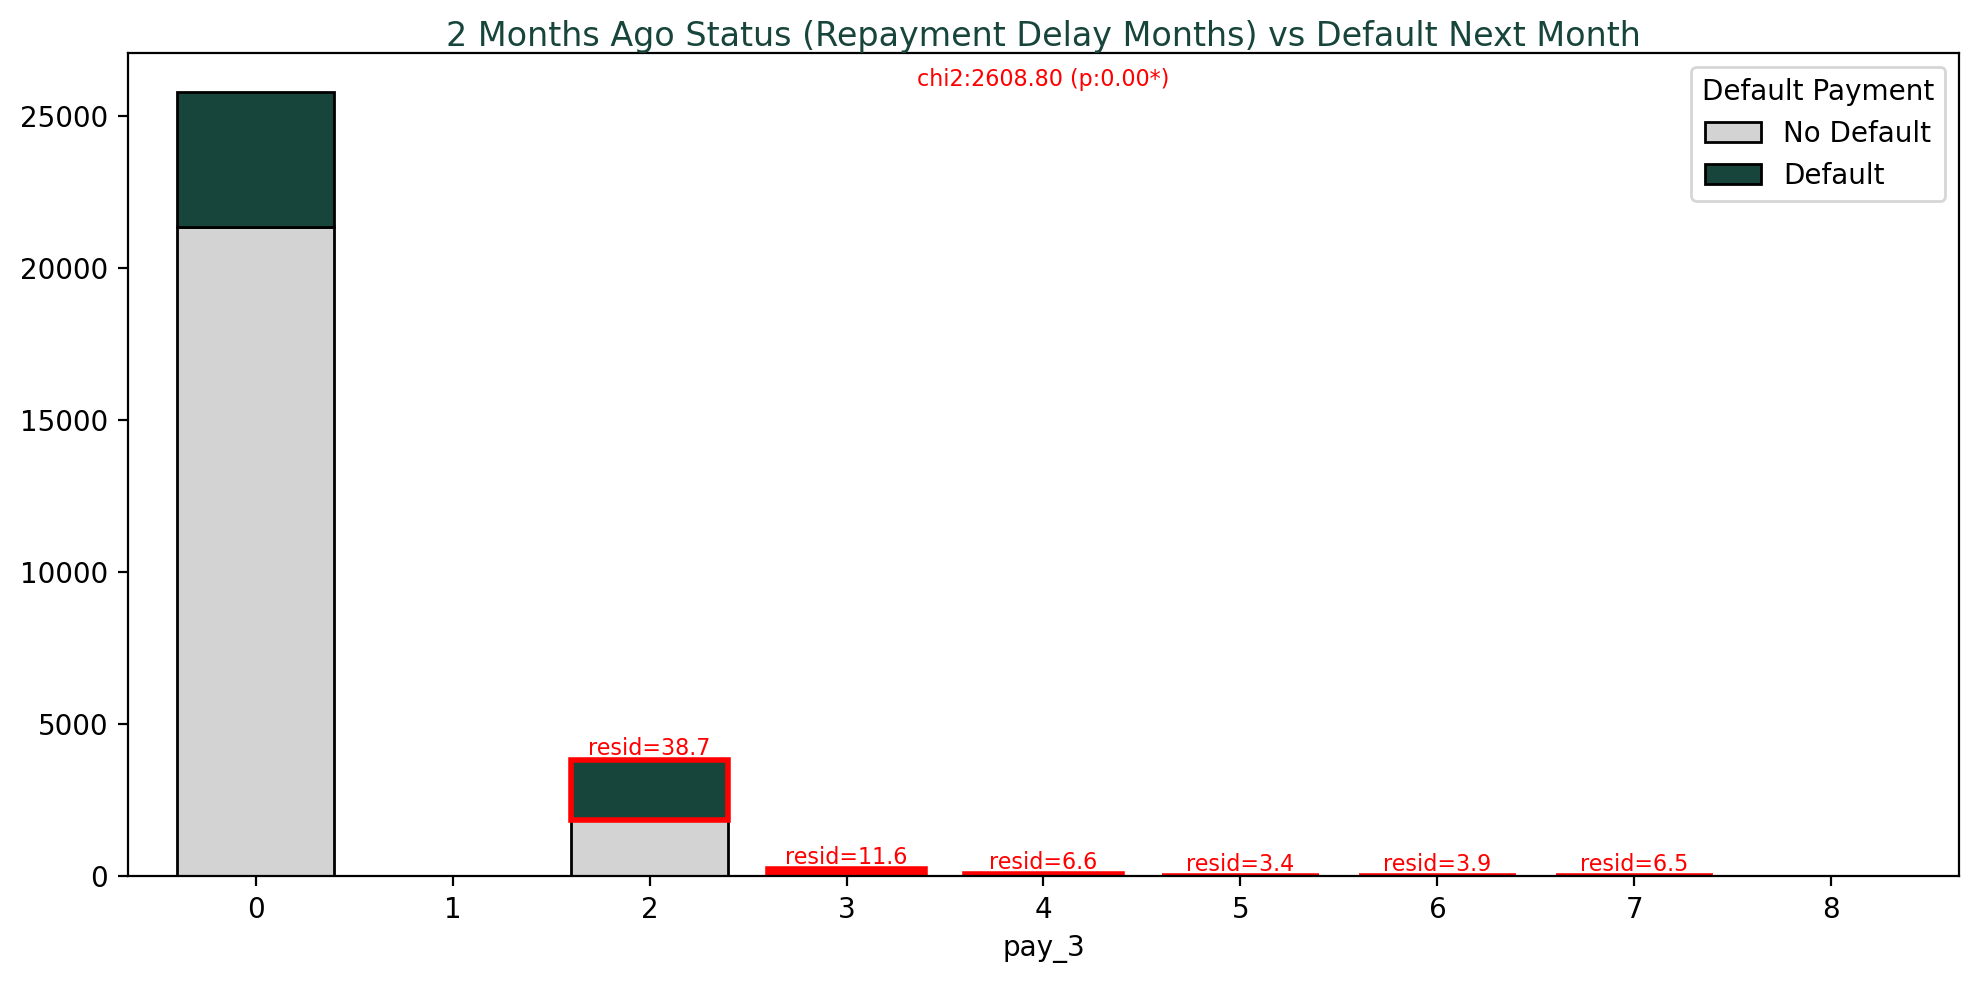

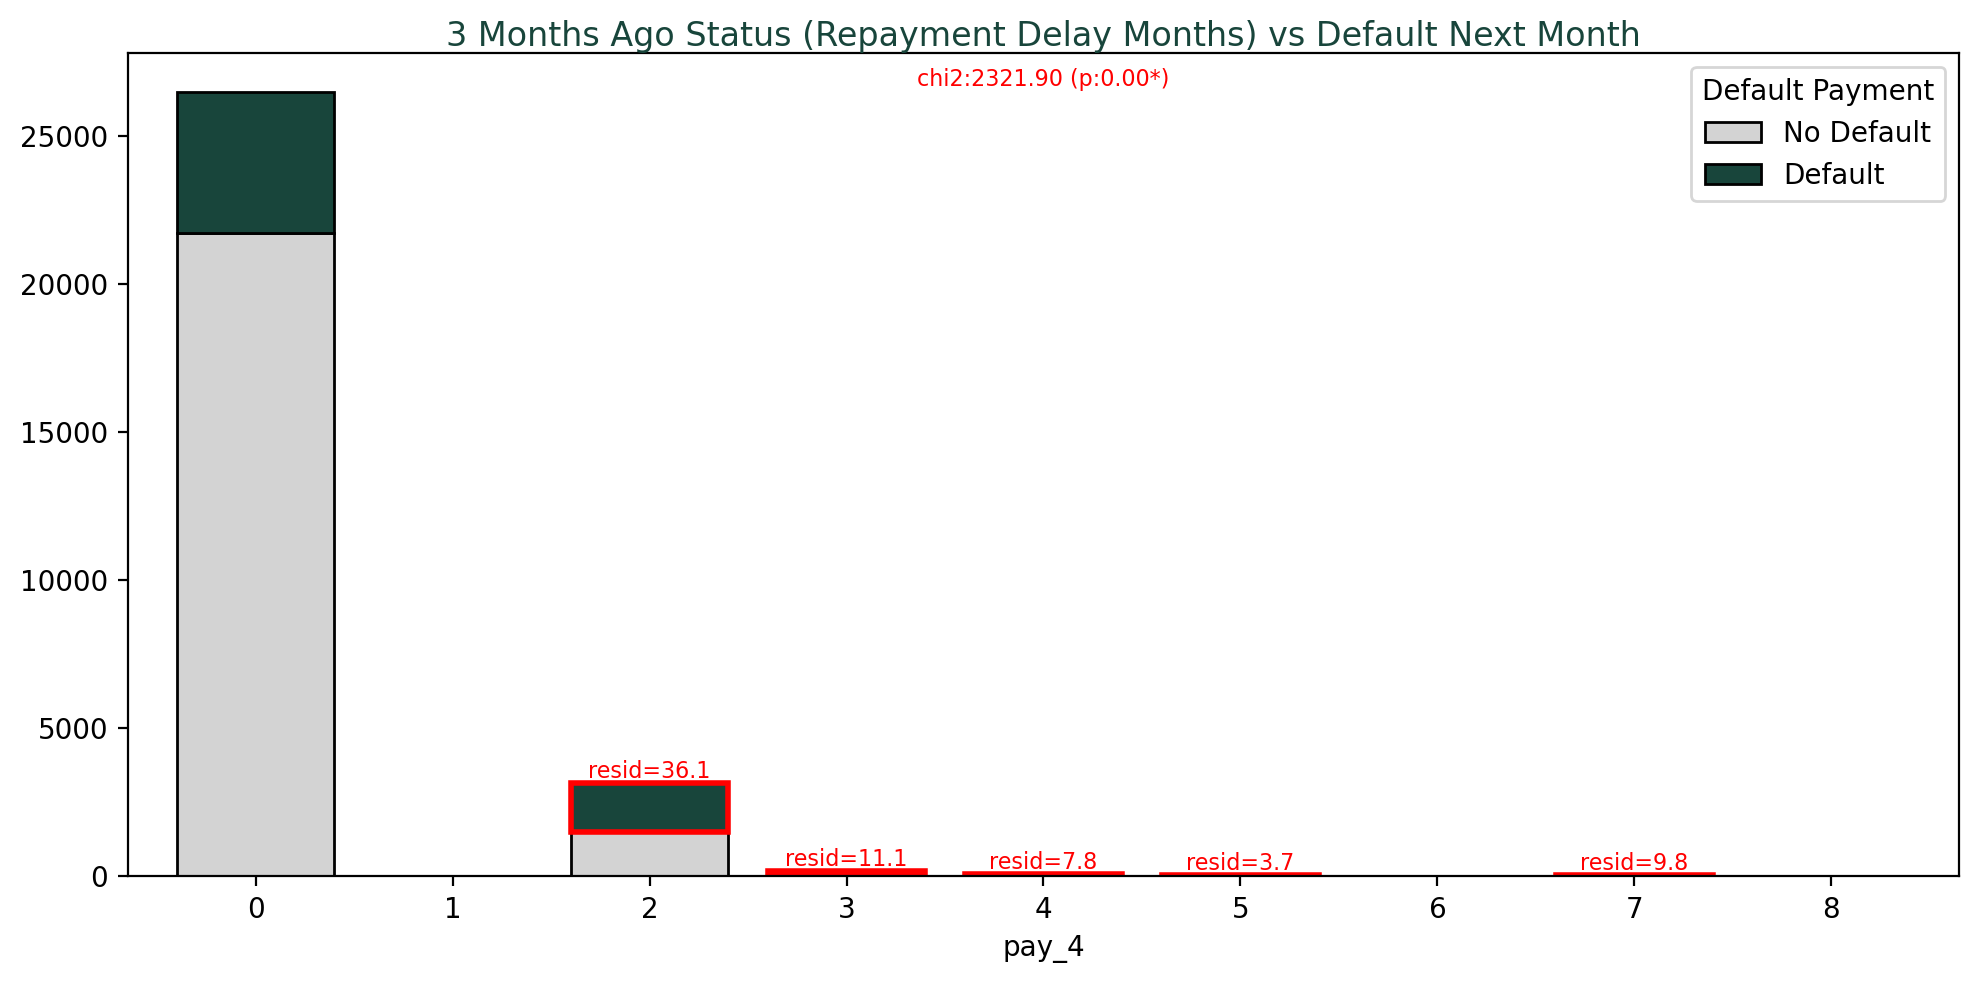

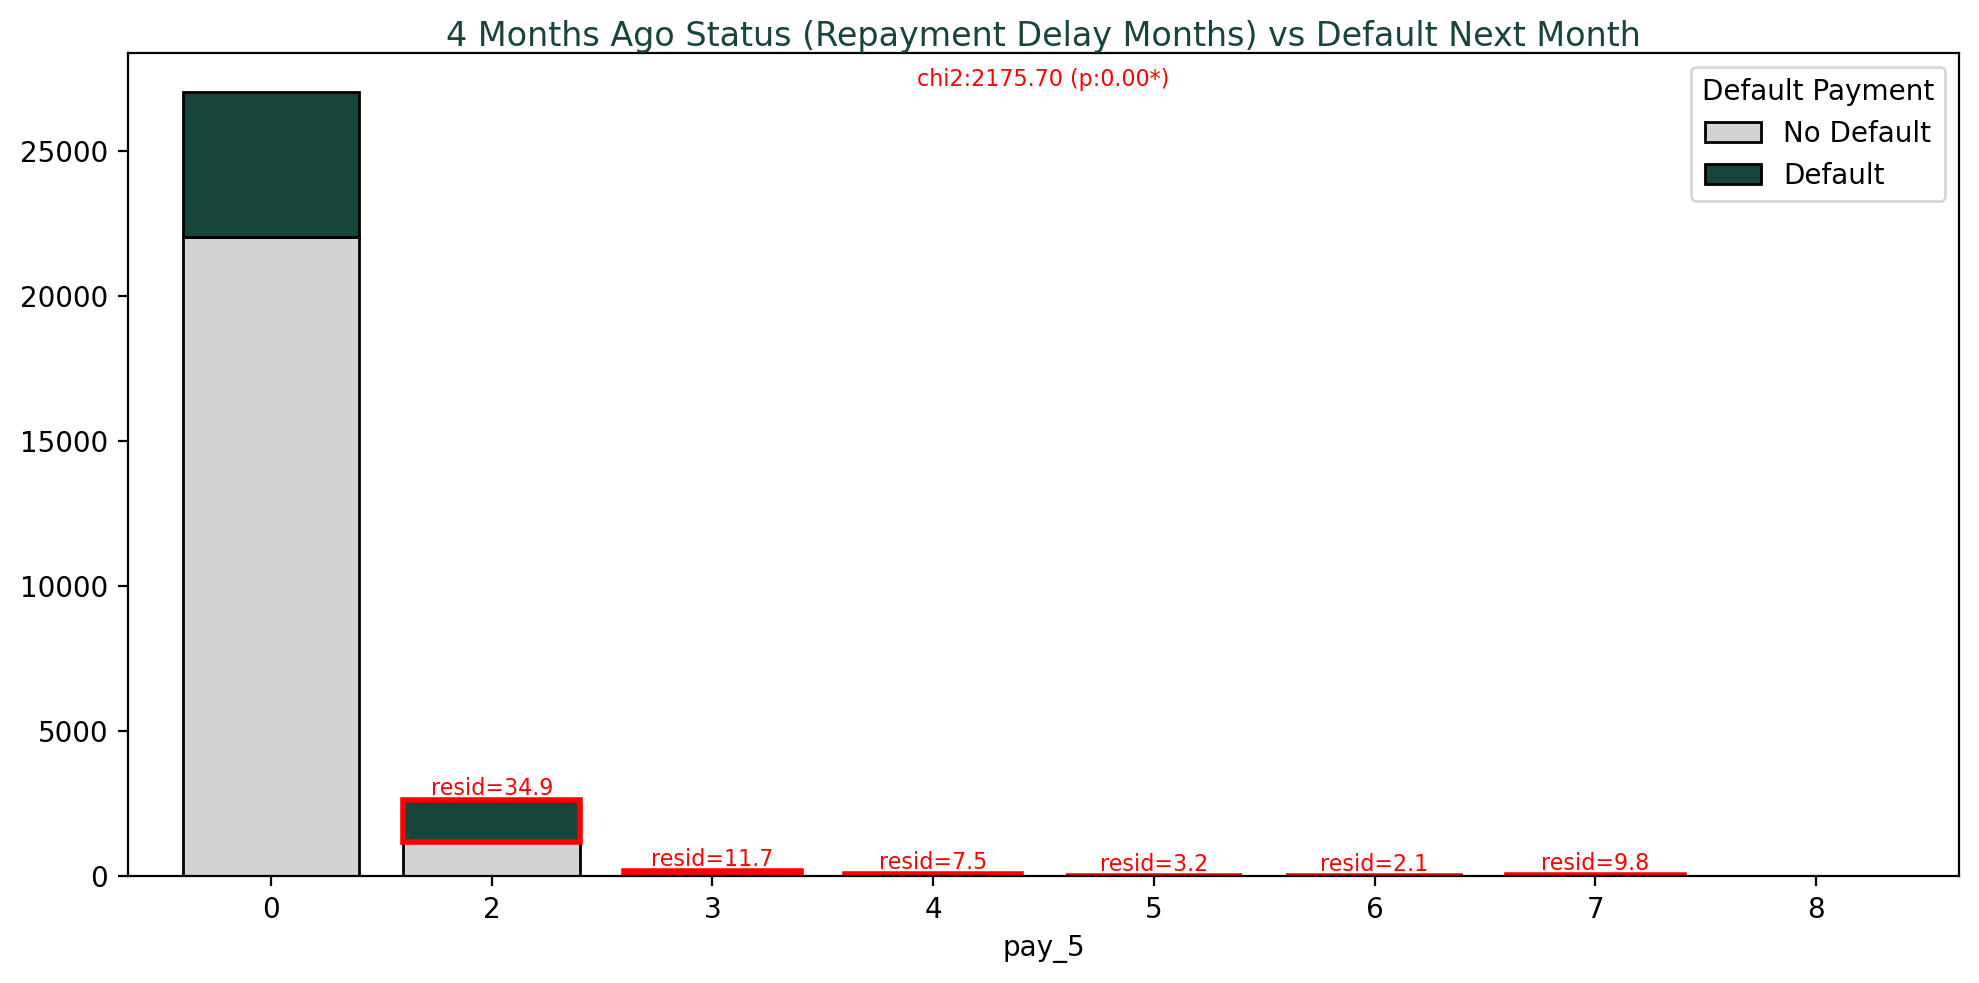

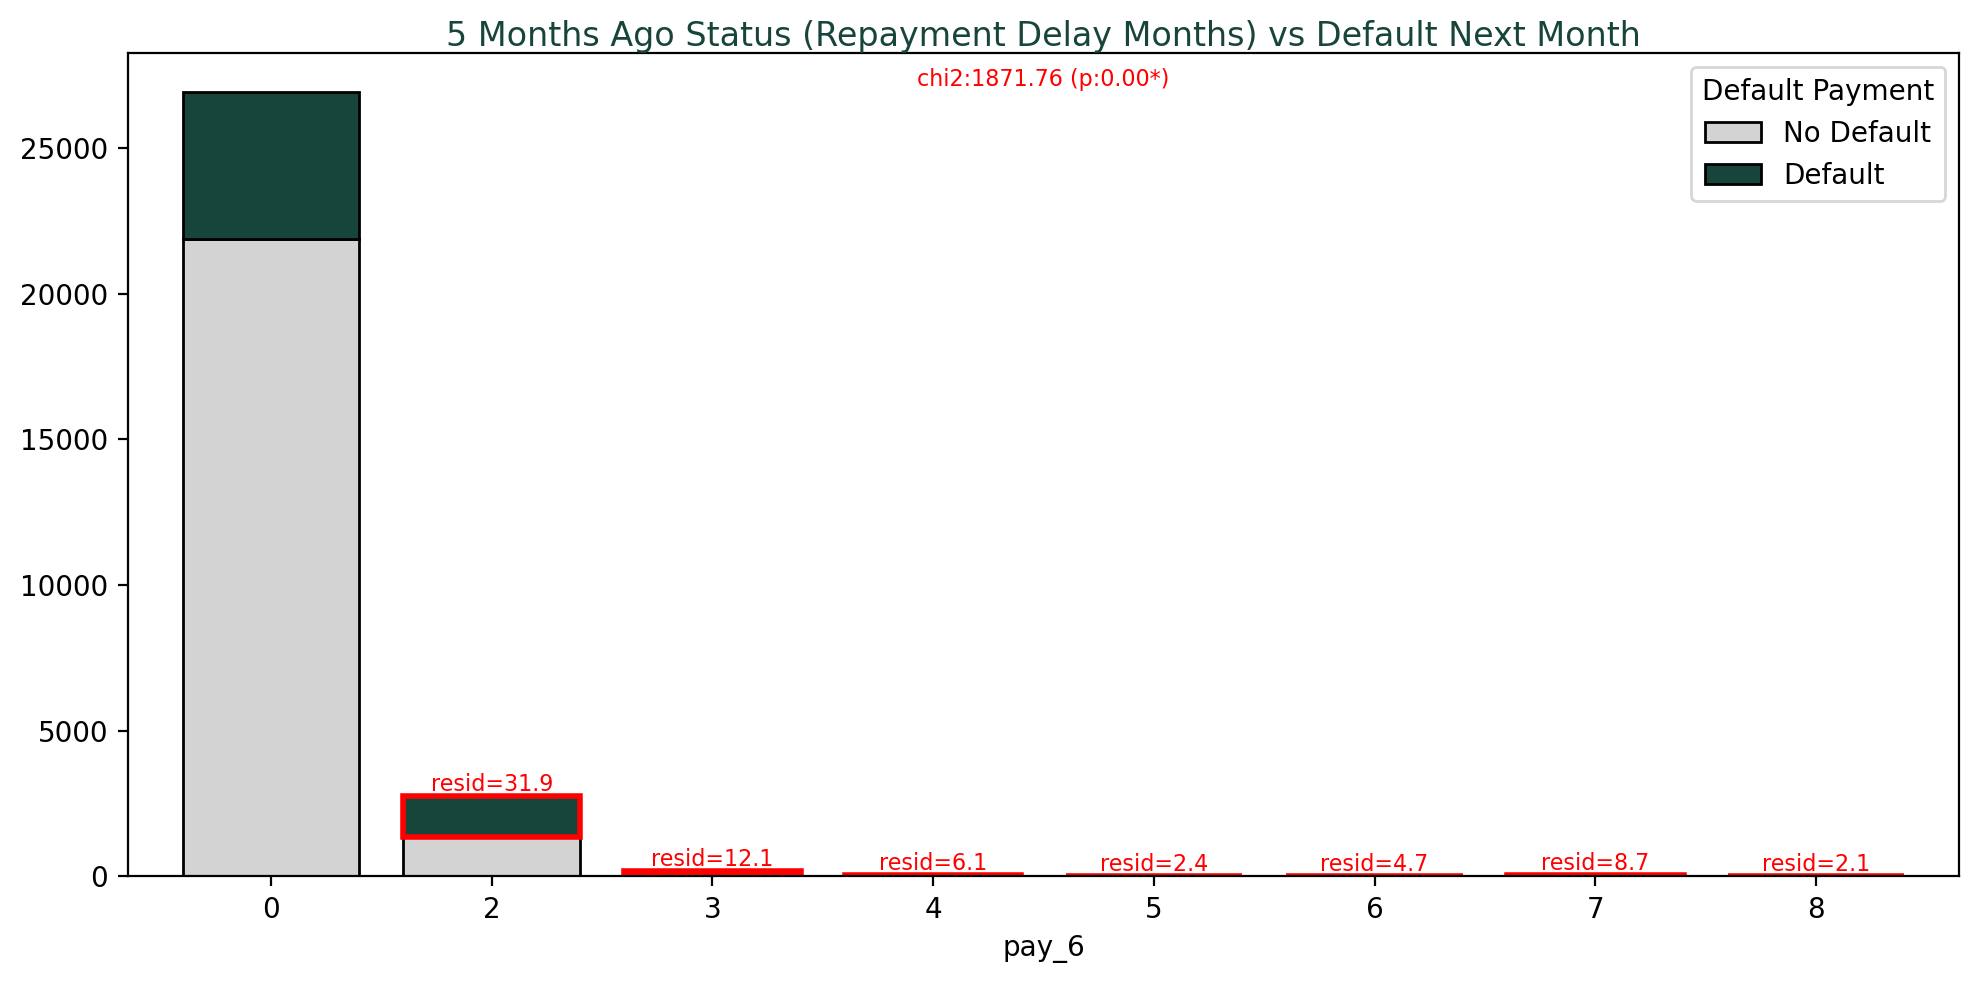

In [24]:
# categorical cols

# cross-tab + chi2 test
important_categorical = []
for col in categorical_cols:
    # handle missing values in column
    if X[col].isnull().any():
        print(f"warning: {col} has missing values, filling with 'Missing'")
        X[col] = X[col].fillna('Missing')
        
    # create contingency table
    crosstab = pd.crosstab(X[col], y) # observed frequencies
    
    # apply mapping to x-axis (index) labels
    if col in mapping_dicts:
        mapped_index = crosstab.index.map(mapping_dicts[col])
        mapped_index = mapped_index.where(mapped_index.notna(), crosstab.index)
        crosstab.index = mapped_index
        
    # check for low expected frequencies
    try:
        # chi-square test
        chi2, p_val, _, expected = stats.chi2_contingency(crosstab) # expected frequencies under null hypothesis
        expected = pd.DataFrame(expected, index=crosstab.index, columns=crosstab.columns)
        
        # warn if expected frequencies are too low (< 5)
        if (expected < 5).any().any():
            print(f"warning: {col} has expected frequencies < 5, chi-square may be unreliable")
        
        # calculate standardized residuals (how much observed counts differ from expected)
        # measure how much observed counts deviate from expected counts under null hypothesis
        # formula: (Observed - Expected) / sqrt(Expected)
        residuals = (crosstab - expected) / np.sqrt(expected + 0.1) # add 0.1 to avoid division by zero
        residuals = pd.DataFrame(residuals, index=crosstab.index, columns=crosstab.columns)
        
        # identify significant categories (residual for class 1 > 2)
        sig_categories = residuals[residuals[1] > 2].index # residual > 2 means p < 0.05 significance level
    except ValueError as e:
        print(f"error: chi-square test failed for {col}: {e}")
        continue
    
    # plot stacked bar chart
    # plt.figure(figsize=(10, 5))
    ax = crosstab.plot(kind='bar', stacked=True, 
                       color=msu_colors, edgecolor='black', 
                       alpha=1, width=0.8, figsize=(10, 5))
    
    ax.legend(
        title='Default Payment',
        labels=[mapping_dicts[target_col][i] for i in crosstab.columns], # column 순서 기반
        loc='best'
    )
        
    # only highlights class 1 bars in categories that significantly contribute to chi-square result
    for i, category in enumerate(crosstab.index):
        if category in sig_categories:
            # explicitly access class 1 bar using container
            bars = ax.containers[1] # class 1 bars (second container)
            if i < len(bars):
                class1_bar = bars[i]
                class1_bar.set_edgecolor('red') # highlight with red
                class1_bar.set_linewidth(2)
                
                # add residual annotation
                height = class1_bar.get_height()
                if height > 0: # only annotate if bar has height
                    ax.text(
                        class1_bar.get_x() + class1_bar.get_width() / 2.,
                        class1_bar.get_y() + height + 0.5, # + height / 2.,
                        # f'↑\nresid={residuals.loc[category, 1]:.1f}',
                        f'resid={residuals.loc[category, 1]:.1f}',
                        ha='center', va='bottom', color='red', fontsize=8
                    )
    
    # if statistically significant variables
    if p_val < 0.05:  
        sig_cats = residuals[residuals[1] > 2].index # categories with strong contribution to chi-square
        for cat in sig_cats:
            important_categorical.append({
                'variable': col,
                'category': cat,
                'std_residual': round(residuals.loc[cat, 1], 2),
                'p-value': f'{p_val:.2e}'
            })
    
    # set plot title and labels
    plt.title(f'{column_mapping[col]} vs {column_mapping[target_col]}', color=msu_colors[1], pad=0)
    plt.xticks(rotation=0 if max([len(str(x)) for x in crosstab.index]) > 7 else 0)
    # plt.legend(title='Target', labels=['Class 0', 'Class 1'])
    
    # add chi-square and p-value annotation
    p_text = f'chi2:{chi2:.2f} (p:{p_val:.2f}' + ('*)' if p_val < 0.05 else ')')
    ax.text(
        0.5, 0.96, p_text,
        transform=ax.transAxes,
        color='red' if p_val < 0.05 else '#909090',
        ha='center', fontsize=8
    )
        
    plt.tight_layout()
    plt.show()

In [25]:
# rank by residual strength
summary_cat = pd.DataFrame(important_categorical)
summary_cat = summary_cat.sort_values('std_residual', ascending=False)

# most predictive category levels
print(summary_cat.head(30).to_string(index=False))

 variable    category  std_residual  p-value
    pay_1           2         51.63 0.00e+00
    pay_2           2         44.63 0.00e+00
    pay_3           2         38.68 0.00e+00
    pay_4           2         36.10 0.00e+00
    pay_5           2         34.94 0.00e+00
    pay_6           2         31.90 0.00e+00
    pay_1           3         20.46 0.00e+00
    pay_1           1         15.27 0.00e+00
    pay_2           3         15.17 0.00e+00
    pay_6           3         12.10 0.00e+00
    pay_5           3         11.72 0.00e+00
    pay_3           3         11.64 0.00e+00
    pay_4           3         11.11 0.00e+00
    pay_4           7          9.78 0.00e+00
    pay_5           7          9.78 0.00e+00
    pay_6           7          8.68 0.00e+00
    pay_1           4          8.56 0.00e+00
    pay_4           4          7.84 0.00e+00
    pay_5           4          7.50 0.00e+00
    pay_3           4          6.61 0.00e+00
    pay_3           7          6.50 0.00e+00
    pay_6 

- recent repayment delays are the #1 red flag
    - pay_1 to pay_6 = 2 (1-month delay) show standardized residuals up to 51.6 --> the strongest signal in the entire dataset
- longer/more severe delays = exponentially higher risk
- males default 4.8x more than expected
- high-school educated borrowers are high-risk 

# Final Cleaning

In [26]:
# age bin
# bins = [20,30,40,50,60,70,80]
# names = ['21-30','31-40','41-50','51-60','61-70','71-80']
# df['age_bin'] = pd.cut(x=df.age, bins=bins, labels=names, right=True)

In [27]:
# encode categorical variables

# convert binary variable: sex
# 1 = male, 2 = female --> change to 0 = male, 1 = female (easier for models)
df['sex'] = df['sex'].map({1: 0, 2: 1}).astype(int)
df.rename(columns={'sex': 'sex_female'}, inplace=True) # rename to make meaning clear
print(df['sex_female'].unique())

[1 0]


In [28]:
# handle multi-category variables
# convert education & marriage --> one-hot encoding (turn categories into 0/1 columns)
df = pd.get_dummies(
    df, 
    columns=['education', 'marriage'], 
    prefix={'education': 'edu', 'marriage': 'marr'},
    # drop_first=True, # to prevent multicollinearity
    dtype=int, # use 0 and 1 only
)

# avoid multicollinearity: drop one dummy column per variable
# drop the last category (e.g., 'Other') instead of first — easier to read/understand
# education: drop last column
edu_cols = [c for c in df.columns if c.startswith('edu_')]
if edu_cols:
    df.drop(columns=[edu_cols[-1]], inplace=True) # remove last column
# marriage: drop last column
marr_cols = [c for c in df.columns if c.startswith('marr_')]
if marr_cols:
    df.drop(columns=[marr_cols[-1]], inplace=True) # remove last column

# show first row of new columns
temp_cols = [col for col in df.columns if ('edu' in col) or ('marr' in col)]
display(df[temp_cols].head(1))

edu_1  edu_2  edu_3  marr_1  marr_2
0      0      1      0       1       0

In [29]:
# handle ordinal variables (ordered categories)
# pay_x: convert from category type --> integer

# pay_cols = [f'pay_{i}' for i in range(1, 7)]
df[pay_cols] = df[pay_cols].astype(int)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   limit_bal   30000 non-null  int64   
 1   sex_female  30000 non-null  int64   
 2   age         30000 non-null  int64   
 3   pay_1       30000 non-null  int64   
 4   pay_2       30000 non-null  int64   
 5   pay_3       30000 non-null  int64   
 6   pay_4       30000 non-null  int64   
 7   pay_5       30000 non-null  int64   
 8   pay_6       30000 non-null  int64   
 9   bill_amt1   30000 non-null  int64   
 10  bill_amt2   30000 non-null  int64   
 11  bill_amt3   30000 non-null  int64   
 12  bill_amt4   30000 non-null  int64   
 13  bill_amt5   30000 non-null  int64   
 14  bill_amt6   30000 non-null  int64   
 15  pay_amt1    30000 non-null  int64   
 16  pay_amt2    30000 non-null  int64   
 17  pay_amt3    30000 non-null  int64   
 18  pay_amt4    30000 non-null  int64   
 19  pay_

In [31]:
# save as csv
# save_file = 'data_cleaned.csv'
# df.to_csv(save_file, index=False)

# Data Split

In [32]:
# target(y), features(X) split
X = df.drop(target_col, axis=1)
y = df[target_col]

# train, test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # 80% train, 20% test
                                                    random_state=SEED, 
                                                    stratify=y, # keep same % of defaults in both sets (imbalanced data)
                                                   )
# recombine for easy EDA and saving
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [33]:
# save as csv
# train_df.to_csv('train.csv', index=False)
# test_df.to_csv('test.csv', index=False)

# Scaling

In [35]:
# feature scaling (standardization)
# -- critical for optimization-based models

# list of continuous & ordinal columns to scale
# skipping one-hot columns - already 0/1
numerical_cols = [
    'limit_bal', 'age', # continuous
    *[f'pay_{i}' for i in range(1, 7)], # delay months (ordinal)
    *[f'bill_amt{i}' for i in range(1, 7)], # bill amounts
    *[f'pay_amt{i}' for i in range(1, 7)] # payment amounts
]
print(numerical_cols)

# Standard Scaler
# mean = 0, std = 1 (great for logistic regression, SVM)
scaler = StandardScaler()
scaler.fit(X_train[numerical_cols]) # fit on training data only

# X_train, X_test transform
# X_train_scaled = X_train.copy()
# X_test_scaled = X_test.copy()
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# rebuilding full datasets
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

['limit_bal', 'age', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']


In [36]:
print_cols(X_train, 2)
print_cols(X_test, 2)

(24000, 26)


limit_bal  sex_female     age   pay_1   pay_2   pay_3   pay_4   pay_5  \
18835    -0.6761           1 -1.1345 -0.4695 -0.4000 -0.3889 -0.3446 -0.3127   
11752     0.9401           1  1.4672 -0.4695 -0.4000 -0.3889 -0.3446 -0.3127   

        pay_6  bill_amt1  bill_amt2  bill_amt3  bill_amt4  bill_amt5  \
18835 -0.3195    -0.0815    -0.0624    -0.0387     0.0062     0.0393   
11752 -0.3195     0.0198     0.0663     0.0990     0.1729     0.2424   

       bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  pay_amt5  pay_amt6  \
18835     0.0865   -0.2138   -0.1676   -0.1818   -0.2166   -0.0966   -0.2932   
11752     0.2854   -0.1873   -0.1752   -0.1831   -0.1844   -0.1866   -0.1795   

       edu_1  edu_2  edu_3  marr_1  marr_2  
18835      0      1      0       0       1  
11752      0      1      0       0       0

(6000, 26)


limit_bal  sex_female     age   pay_1   pay_2   pay_3   pay_4   pay_5  \
21961    -0.1374           1 -0.9177 -0.4695 -0.4000 -0.3889 -0.3446 -0.3127   
21003     0.2474           0 -0.3757  2.1586 -0.4000 -0.3889 -0.3446 -0.3127   

        pay_6  bill_amt1  bill_amt2  bill_amt3  bill_amt4  bill_amt5  \
21961 -0.3195    -0.6753    -0.6666    -0.5963    -0.6015     0.4911   
21003 -0.3195     1.4848     1.6005     0.5041    -0.6737    -0.6642   

       bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  pay_amt5  pay_amt6  \
21961     0.4874   -0.2319   -0.0118   -0.0353    4.3094   -0.1187   -0.1250   
21003    -0.6534    0.1158   -0.0854   -0.2882   -0.3152   -0.3228   -0.2932   

       edu_1  edu_2  edu_3  marr_1  marr_2  
21961      0      1      0       0       1  
21003      0      1      0       0       1

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 18835 to 2365
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   limit_bal   24000 non-null  float64
 1   sex_female  24000 non-null  int64  
 2   age         24000 non-null  float64
 3   pay_1       24000 non-null  float64
 4   pay_2       24000 non-null  float64
 5   pay_3       24000 non-null  float64
 6   pay_4       24000 non-null  float64
 7   pay_5       24000 non-null  float64
 8   pay_6       24000 non-null  float64
 9   bill_amt1   24000 non-null  float64
 10  bill_amt2   24000 non-null  float64
 11  bill_amt3   24000 non-null  float64
 12  bill_amt4   24000 non-null  float64
 13  bill_amt5   24000 non-null  float64
 14  bill_amt6   24000 non-null  float64
 15  pay_amt1    24000 non-null  float64
 16  pay_amt2    24000 non-null  float64
 17  pay_amt3    24000 non-null  float64
 18  pay_amt4    24000 non-null  float64
 19  pay_amt5    24000 non-null 

In [ ]:
# save as csv
# train_df.to_csv('train_scaled.csv', index=False)
# test_df.to_csv('test_scaled.csv', index=False)